In [227]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import cv2
import ast


In [259]:
def map_year_to_decade(year):
    return (year // 10) * 10

def rename_image(image_name):
    if ".png" not in image_name:
        return f"{image_name}.png"
    else:
        return image_name

def xywh_to_xyxy(x_center, y_center, width, height):
    x_top_left = int(x_center - (width / 2))
    y_top_left = int(y_center - (height / 2))
    x_bottom_right = int(x_center + (width / 2))
    y_bottom_right = int(y_center + (height / 2))
    return x_top_left, y_top_left, x_bottom_right, y_bottom_right
    
def filter_preduction(prediction_result):
    #prediction_dict = ast.literal_eval(prediction_result)
    prediction_result = f"{prediction_result.replace('array(','').replace(', dtype=float32)','')}"
    prediction_results_dict = ast.literal_eval(prediction_result)
    #prediction_results_dict = eval(prediction_result.replace('np.array', ''))


    #print(prediction_results_dict)
    
    prediction = prediction_results_dict['prediction']
    image_name = prediction_results_dict['image_name']
    number = prediction_results_dict['number of objects']
    pred = []
    if number > 0:
        for i in prediction:
            conf = i['confidence']
            if conf > 0.6:
                pred.append(i)
        output= {
                           "image_name" : image_name,
                           "number of objects":len(pred),
                            "prediction" : pred
                            }
        #print(output)
        #print("-------------------------")
        return output
    else:
        return prediction_results_dict

def convert_string_to_dict(string):
    try:
        fixed_string = string.replace("array(", "").replace(", dtype=float32)", "")
        return ast.literal_eval(fixed_string)
    except ValueError:
        return None


def save_image_with_boxes(row, save_path, column_name = 'prediction'):
    # Load the image
    image_path = f"{images_path}/{row['image_name']}"
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for pred in row[column_name]:
        x_center, y_center, w, h = pred['xywh']
        x_top_left, y_top_left, x_bottom_right, y_bottom_right = xywh_to_xyxy(x_center, y_center, w, h)

        label = pred['object_name']
        confidence = pred['confidence']
        label_with_conf = f'{label}: {confidence:.2f}'

        cv2.rectangle(img, (x_top_left, y_top_left), (x_bottom_right, y_bottom_right), (0, 255, 0), 2)
        
        text_x = x_top_left
        text_y = y_top_left - 10 if y_top_left - 10 > 10 else y_top_left + 20  # Adjust text position if too close to top
        cv2.putText(img, label_with_conf, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, img_bgr)

def count_objects(df, column_name, objects_to_count):
    object_counts = {object_name: 0 for object_name in objects_to_count}

    for object_list in df[column_name]:
        if isinstance(object_list, list):
            for obj in objects_to_count:
                object_counts[obj] += object_list.count(obj)
        else:
            print(object_list)

    return object_counts

def get_average_object(df, decade, genre, pos = False):

    filtered_df = df[
    (df['m_single_genre'] == genre) |
    (df['genres_mu'].fillna('').str.split(',').apply(lambda genres: genre in genres))
    ]

    filtered_df = filtered_df[
    (filtered_df['decade'] == decade) 
    ]
    
    
    unique_objects = set(x for sublist in filtered_df['unique_object_names'] for x in sublist)
    row_count = count_objects(filtered_df,'unique_object_names',unique_objects)
    appear_count = count_objects(filtered_df,'objects_names',unique_objects)
    
    if pos:
        unique_objects = set(x for sublist in filtered_df['unique_object_names_pos'] for x in sublist)
        row_count = count_objects(filtered_df,'unique_object_names_pos',unique_objects)
        appear_count = count_objects(filtered_df,'objects_names_pos',unique_objects)
        
    avg = []
    
    for i in row_count:
        if row_count[i] > 10:
            average = appear_count[i] / row_count[i]
            percentage = (row_count[i] * 100)/len(filtered_df)
            
            avg.append({
                            "object" : i,
                            "average": average,
                            "appear_count" :appear_count[i],
                            "row_count" :row_count[i],
                            "percentage" : percentage
                        })
    return ({
                        "decade" : decade,
                        "genre" : genre,
                        "number_of_rows" :len(filtered_df),
                        "Average" : avg
                    })


def plot_object_distribution(df, object_name, column_name = 'average_average'):
    filtered_df = df[
        (df['average_object'] == object_name) 
        ]
    filtered_df['decade'] = filtered_df['decade'].astype(str)

    decade_palette = {"1970.0": "#b6d7a8", "1980.0": "#45818e", "1990.0": "#9fc5e8", "2000.0": "#b4a7d6"}
    
    # Create the bar plot with 'genre' on the x-axis, 'average_average' on the y-axis, and 'decade' as hue
    plt.figure(figsize=(20, 8))
    barplot = sns.barplot(
        data=filtered_df,
        x='genre',
        y=column_name,
        hue='decade',
        palette=decade_palette  # Use the custom palette for colors
    )
    
    # Adjust the width of the bars to increase space between them
    for bar in barplot.patches:
        bar.set_width(bar.get_width() * 0.8)
    
    plt.title(f'{column_name} of "{object_name}" by Genre and Decade')
    plt.xlabel('Genre')
    plt.ylabel(f'Average Count ')
    plt.xticks(rotation=45)
    
    # Place the legend outside of the plot area
    plt.legend(title='Decade', bbox_to_anchor=(1.01, 1), borderaxespad=0)
    
    plt.tight_layout()
    plt.show()
    

In [ ]:
images_path = "input/merged_dataset/images_merged"

In [197]:
df = pd.read_csv(f"input/merged_dataset/mergged_object_detection_final.csv", header=0)
#df = df.drop(['boxes', 'confidence','prediction','num_objects','resolution_row','dimension_row','objects_names',"image_name","number_of_objects", "total_object_counts"], axis=1)
df['decade'] = df['m_year'].apply(map_year_to_decade)
df = df[df['decade'] > 1960]
df['decade'] = df['decade'].replace(2010, 2000)
df = df[df['genres_list'] < 5]
df['m_name_image'] = df['m_name_image'].apply(rename_image)







In [198]:
df['prediction_results_post'] = df['prediction_results'].apply(filter_preduction)
df['prediction_results'] = df['prediction_results'].apply(convert_string_to_dict)

df['prediction_'] = df['prediction_results'].apply(lambda x: x['prediction'])
df['num_objects'] = df['prediction_results'].apply(lambda x: x['number of objects'])
df['objects_names'] = df['prediction_results'].apply(lambda x: [pred['object_name'] for pred in x['prediction']])
df['boxes'] = df['prediction_results'].apply(lambda x: [pred['xywh'] for pred in x['prediction']])
df['confidence'] = df['prediction_results'].apply(lambda x: [pred['confidence'] for pred in x['prediction']])

df['unique_object_names'] = df['objects_names'].apply(lambda x: list(set(x)))

df['prediction_pos'] = df['prediction_results_post'].apply(lambda x: x['prediction'])
df['num_objects_pos'] = df['prediction_results_post'].apply(lambda x: x['number of objects'])
df['objects_names_pos'] = df['prediction_results_post'].apply(lambda x: [pred['object_name'] for pred in x['prediction']])
df['boxes_pos'] = df['prediction_results_post'].apply(lambda x: [pred['xywh'] for pred in x['prediction']])
df['confidence_pos'] = df['prediction_results_post'].apply(lambda x: [pred['confidence'] for pred in x['prediction']])

df['unique_object_names_pos'] = df['objects_names_pos'].apply(lambda x: list(set(x)))


In [ ]:
object_counts = (
    df['objects_names']
    .apply(lambda x: pd.Series(x))  # Expand each list into its own series (wide format)
    .apply(pd.Series.value_counts, axis=1)  # Count occurrences across rows
    .fillna(0)  # Replace NaN with 0 (for objects not present)
    .astype(int)  # Ensure counts are integers
)

# Rename columns to prepend 'object_' to each object name
object_counts.columns = ['object_' + col for col in object_counts.columns]

# Concatenate the original DataFrame with the new object count columns
df_final = pd.concat([df, object_counts], axis=1)
df_final


In [ ]:
df_final

In [222]:
df.to_csv('input/merged_dataset/mergged_object_detection_post_processed.csv', index=False)


## Without post processing

 Horses, Metal but also strange creatures are taken as horses
 Tennis racket, skateboards are actually guitars

In [ ]:
def display_image_with_boxes_inline(row):
    # Load the image
    image_path = f"{images_path}/{row['image_name']}"
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Iterate over the predictions in the row and draw bounding boxes
    for pred in row['prediction']:
        x_center, y_center, w, h = pred['xywh']
        x_top_left, y_top_left, x_bottom_right, y_bottom_right = xywh_to_xyxy(x_center, y_center, w, h)

        label = pred['object_name']
        confidence = pred['confidence']
        label_with_conf = f'{label}: {confidence:.2f}'

        # Draw rectangle on image
        cv2.rectangle(img, (x_top_left, y_top_left), (x_bottom_right, y_bottom_right), (0, 255, 0), 2)
        
        # Put label with confidence near the bounding box
        text_x = x_top_left
        text_y = y_top_left - 10 if y_top_left - 10 > 10 else y_top_left + 20  # Adjust text position if too close to top
        cv2.putText(img, label_with_conf, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')  # Hide the axes
    plt.show()


df['image_name'] = df['prediction_results'].apply(lambda x: x['image_name'])
df['number_of_objects'] = df['prediction_results'].apply(lambda x: x['number of objects'])
df['prediction'] = df['prediction_results'].apply(lambda x: x['prediction'])

# Display the first 10 images with bounding boxes
filtered_df = df[
    (df['m_single_genre'] == 'Blues') |
    (df['genres_mu'].fillna('').str.split(',').apply(lambda genres: 'Blues' in genres))
    ]

#for index, row in df.iterrows():
#    if row['number_of_objects'] > 10:
#        display_image_with_boxes_inline(row)
df_birds = filtered_df[filtered_df['unique_object_names'].apply(lambda x: 'tie' in x)]

##
for index, row in df_birds[:30].iterrows():
    print(row['m_single_genre'], row['genres_mu'])
    display_image_with_boxes_inline(row)


In [201]:
objects_counts = df['num_objects'].value_counts()
objects_counts_df = objects_counts.reset_index()
objects_counts_df['Percentage'] = round((objects_counts_df['count'] * 100) / len(df_final), 3)
objects_counts_df

,num_objects,count,Percentage
0,0,7794,38.575
1,1,7428,36.763
2,2,2418,11.967
3,3,1036,5.127
4,4,710,3.514
5,5,432,2.138
6,6,192,0.950
7,7,105,0.520
8,8,44,0.218
9,9,20,0.099


In [239]:
object_counts = (
    df['unique_object_names']
    .apply(lambda x: pd.Series(x))  # Expand each list into its own series (wide format)
    .apply(pd.Series.value_counts, axis=1)  # Count occurrences across rows
    .fillna(0)  # Replace NaN with 0 (for objects not present)
    .astype(int)  # Ensure counts are integers
)

# Rename columns to prepend 'object_' to each object name
object_counts.columns = ['object_' + col for col in object_counts.columns]

# Concatenate the original DataFrame with the new object count columns
df_final_unique = pd.concat([df, object_counts], axis=1)



In [240]:
df_final_unique

,genres_mu,genres_list,m_id,m_name_image,m_url,m_release,m_title,m_year,m_single_genre,m_artist_id,...,object_toilet,object_toothbrush,object_traffic light,object_train,object_truck,object_tv,object_umbrella,object_vase,object_wine glass,object_zebra
0,"Jazz,Vocal Jazz,Vocal Pop,Pop",4.0,TRAACPD128F931C3E7,8908_B000005L7O.png,http://ecx.images-amazon.com/images/I/41XRNKVC...,Evolution,Midnight Sun,1993.0,NaN,AREUZEN1187FB48155,...,0,0,0,0,0,0,0,0,0,0
1,NaN,1.0,TRAADMH128F9343E59,13540_TRAADMH128F9343E59.png,http://artwork-cdn.7static.com/static/img/slee...,A Bothered Mind,Glory Be,2004.0,Blues,AR7TTS41187B9B42D3,...,0,0,0,0,0,0,0,0,0,0
2,NaN,1.0,TRAAFHY12903CB3BB3,12864_TRAAFHY12903CB3BB3.png,http://artwork-cdn.7static.com/static/img/slee...,La Raza,Get Off the Fence,2010.0,Metal,ARGBE8R1187FB4D4FA,...,0,0,0,0,0,0,0,0,0,0
3,"R&B,Pop Rap,Rap & Hip-Hop,Pop",4.0,TRAAFUJ128F933F42B,8387_B000005AYV.png,http://ecx.images-amazon.com/images/I/514n0OIo...,Waterbed Hev,Wanna Be A Player,1997.0,NaN,ARNVH8S1187FB52F86,...,0,0,0,0,0,0,0,0,0,0
4,"Country,Pop,Cowboy",3.0,TRAAGOH128F42593CE,5555_B000002LNS.png,http://ecx.images-amazon.com/images/I/51zw0yVb...,The Very Best Of,You Feel Good All Over,2002.0,NaN,ARLWR721187B9A03C9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200,"R&B,Rap & Hip-Hop",2.0,TRZZXPN128F4288890,26099_B000PSRNNY.png,http://ecx.images-amazon.com/images/I/519SIwxt...,The Hollywood Recordings,Hollywood (Redux),2007.0,NaN,ARWCBT01187FB516E8,...,0,0,0,0,0,0,0,0,0,0
20201,NaN,1.0,TRZZYFC12903CA4F06,16669_TRZZYFC12903CA4F06.png,http://artwork-cdn.7static.com/static/img/slee...,Same As It Ever Was [Explicit Version],Still Got A Lotta Love,1994.0,Rap,AR5SDCC1187FB3FE24,...,0,0,0,0,0,0,0,0,0,0
20202,NaN,1.0,TRZZYOF128F4255016,18132_TRZZYOF128F4255016.png,http://artwork-cdn.7static.com/static/img/slee...,Gentle Rain,Nightsong,2006.0,New Age,ARI4S0E1187B9B06C0,...,0,0,0,0,0,0,0,0,0,0
20203,"India & Pakistan,Far East & Asia,World Music,Pop",4.0,TRZZYUJ128F1468DEA,12580_B00000ID4T.png,http://ecx.images-amazon.com/images/I/41fOt0Ql...,The Zen Kiss,Shehnai Song,1999.0,NaN,ARRU9VN1187FB53EDB,...,0,0,0,0,0,0,0,0,0,0


In [241]:
unique_objects = set(x for sublist in df['unique_object_names'] for x in sublist)

print(unique_objects)
print(len(unique_objects))

{'baseball glove', 'donut', 'chair', 'tv', 'teddy bear', 'wine glass', 'spoon', 'banana', 'clock', 'couch', 'dog', 'fire hydrant', 'bottle', 'mouse', 'toilet', 'hair drier', 'knife', 'laptop', 'tennis racket', 'airplane', 'snowboard', 'vase', 'bear', 'backpack', 'apple', 'car', 'giraffe', 'surfboard', 'remote', 'frisbee', 'train', 'keyboard', 'cat', 'motorcycle', 'orange', 'baseball bat', 'bus', 'fork', 'boat', 'cake', 'carrot', 'cell phone', 'bed', 'traffic light', 'umbrella', 'skis', 'oven', 'sheep', 'potted plant', 'suitcase', 'tie', 'truck', 'elephant', 'bicycle', 'sandwich', 'zebra', 'bird', 'bowl', 'bench', 'microwave', 'horse', 'skateboard', 'scissors', 'refrigerator', 'cup', 'toothbrush', 'stop sign', 'pizza', 'cow', 'hot dog', 'handbag', 'book', 'dining table', 'sink', 'parking meter', 'kite', 'sports ball', 'person', 'broccoli'}
79


In [242]:
object_counts = {col.split('_')[1]: df_final_unique[col].sum() for col in df_final_unique.columns if col.startswith('object_')}

print(f"Number of objects individually {len(object_counts)}")


Number of objects individually 79


In [243]:
object_counts_df = pd.DataFrame(list(object_counts.items()), columns=['Object', 'Count'])
object_counts_df_sorted = object_counts_df.sort_values('Count', ascending=False)
object_counts_df_sorted.reset_index(drop=True, inplace=True)
object_counts_df_sorted['Percentage'] = round((object_counts_df_sorted['Count'] * 100) / object_counts_df_sorted['Count'].sum(), 3)

object_counts_df_sorted[:11] #

,Object,Count,Percentage
0,person,10522,69.319
1,book,460,3.031
2,tie,454,2.991
3,tv,370,2.438
4,car,225,1.482
5,clock,217,1.430
6,chair,197,1.298
7,bird,168,1.107
8,dog,163,1.074
9,horse,140,0.922


In [244]:
 object_counts_df_sorted['Count'].sum()

15179

In [245]:
unique_decades = sorted(df['decade'].dropna().unique())
unique_genre = sorted(df['m_single_genre'].dropna().unique())

In [ ]:
average = []
for genre in unique_genre:
    for decade in unique_decades:
        print(genre, decade)
        average.append(get_average_object(df, decade, genre))

In [224]:
for genre in unique_genre:
    to_save_df = df[
    (df['m_single_genre'] == genre) |
    (df['genres_mu'].fillna('').str.split(',').apply(lambda genres: genre in genres))
    ]
    save_directory = f"saved_images/{genre}"
    
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    # Save the first 10 images with bounding boxes
    for index, row in to_save_df[:50].iterrows():
        save_image_name = os.path.join(save_directory, os.path.basename(row['image_name']))
        save_image_with_boxes(row, save_image_name)

In [211]:
average_df = pd.json_normalize(average, 'Average', ['decade', 'genre', 'number_of_rows'], 
                       record_prefix='average_', errors='ignore')



In [212]:
average_df[(average_df['genre'] == 'Gospel') 
            ]

,average_object,average_average,average_appear_count,average_row_count,average_percentage,decade,genre,number_of_rows
41,person,2.600000,39,15,78.947368,1990.0,Gospel,19
42,person,2.142857,45,21,95.454545,2000.0,Gospel,22


In [213]:

unique_genre = sorted(average_df['genre'].dropna().unique())

top_stats = []

for genre in unique_genre:
    filtered_df = average_df[average_df['genre'] == genre]
    
    for decade in unique_decades:
        decade_df = filtered_df[filtered_df['decade'] == decade]
        
        top_rows = decade_df.nlargest(3, 'average_percentage')
        
        for rank, (index, row) in enumerate(top_rows.iterrows(), start=1):
            top_stats.append({
                "genre": genre,
                "decade": decade,
                "rank": rank,
                "object": row['average_object'],  # Replace with your actual column name if different
                "average": row['average_average'],  # Replace with your actual column name if different
                "percentage": row['average_percentage']  # Replace with your actual column name if different
            })

top_stats_df = pd.DataFrame(top_stats)


In [226]:
 top_stats_df[top_stats_df['rank'] == 2][:40]

,genre,decade,rank,object,average,percentage
6,Blues,1990.0,2,tv,1.000000,7.182320
15,Country,2000.0,2,tie,1.214286,2.928870
20,Dance & Electronic,2000.0,2,book,1.266667,1.986755
24,Electronic,1990.0,2,tv,1.000000,2.981030
26,Electronic,2000.0,2,tv,1.031250,1.958384
36,Jazz,1980.0,2,tv,1.000000,7.831325
39,Jazz,1990.0,2,tie,1.033333,4.885993
42,Jazz,2000.0,2,tie,1.129032,3.587963
53,Metal,2000.0,2,clock,1.058824,2.869198
58,Pop,1970.0,2,book,1.266667,4.587156


In [215]:

unique_object = sorted(average_df['average_object'].dropna().unique())

average_object_stats = []
for object in unique_object:
    filtered_df = average_df[
            (average_df['average_object'] == object) 
            ]
    max_average_index = filtered_df['average_percentage'].idxmax()
    min_average_index = filtered_df['average_percentage'].idxmin()
    # Get the row with the maximum 'average_average' value
    max_average_row = filtered_df.loc[max_average_index]
    min_average_row = filtered_df.loc[min_average_index]

    average_object_stats.append({
                            "object" : object,
                            "max_genre": max_average_row.genre,
                            "max_decade": max_average_row.decade,
                            "max_average" : max_average_row.average_average,
                            "max_percentage" : max_average_row.average_percentage,
                            "min_genre": min_average_row.genre,
                            "min_decade": min_average_row.decade,
                            "min_average" : min_average_row.average_average,
                            "min_percentage" : min_average_row.average_percentage,
                        })
    # Calculate the mean of the 'average_average' column



In [216]:
average_object_stats_df = pd.DataFrame(average_object_stats)
average_object_stats_df

,object,max_genre,max_decade,max_average,max_percentage,min_genre,min_decade,min_average,min_percentage
0,airplane,Rock,2000.0,1.090909,0.294354,Rock,2000.0,1.090909,0.294354
1,bed,Pop,2000.0,1.032258,0.802901,Pop,1990.0,1.000000,0.614525
2,bench,Pop,2000.0,1.000000,0.336700,Pop,2000.0,1.000000,0.336700
3,bird,Metal,2000.0,1.416667,2.025316,Pop,2000.0,1.740741,0.699301
4,boat,Rock,2000.0,1.000000,0.321113,Pop,2000.0,1.000000,0.310800
5,book,Blues,1990.0,1.363636,6.077348,Metal,2000.0,1.076923,1.097046
6,bottle,Rock,2000.0,1.312500,0.428151,Pop,2000.0,1.687500,0.414400
7,car,Rap,2000.0,1.117647,2.533532,Rock,1990.0,1.363636,0.716612
8,cat,Rock,2000.0,1.050000,0.535189,Pop,2000.0,1.071429,0.362600
9,cell phone,Pop,2000.0,1.052632,0.492100,Rock,2000.0,1.000000,0.294354


/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1160974776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


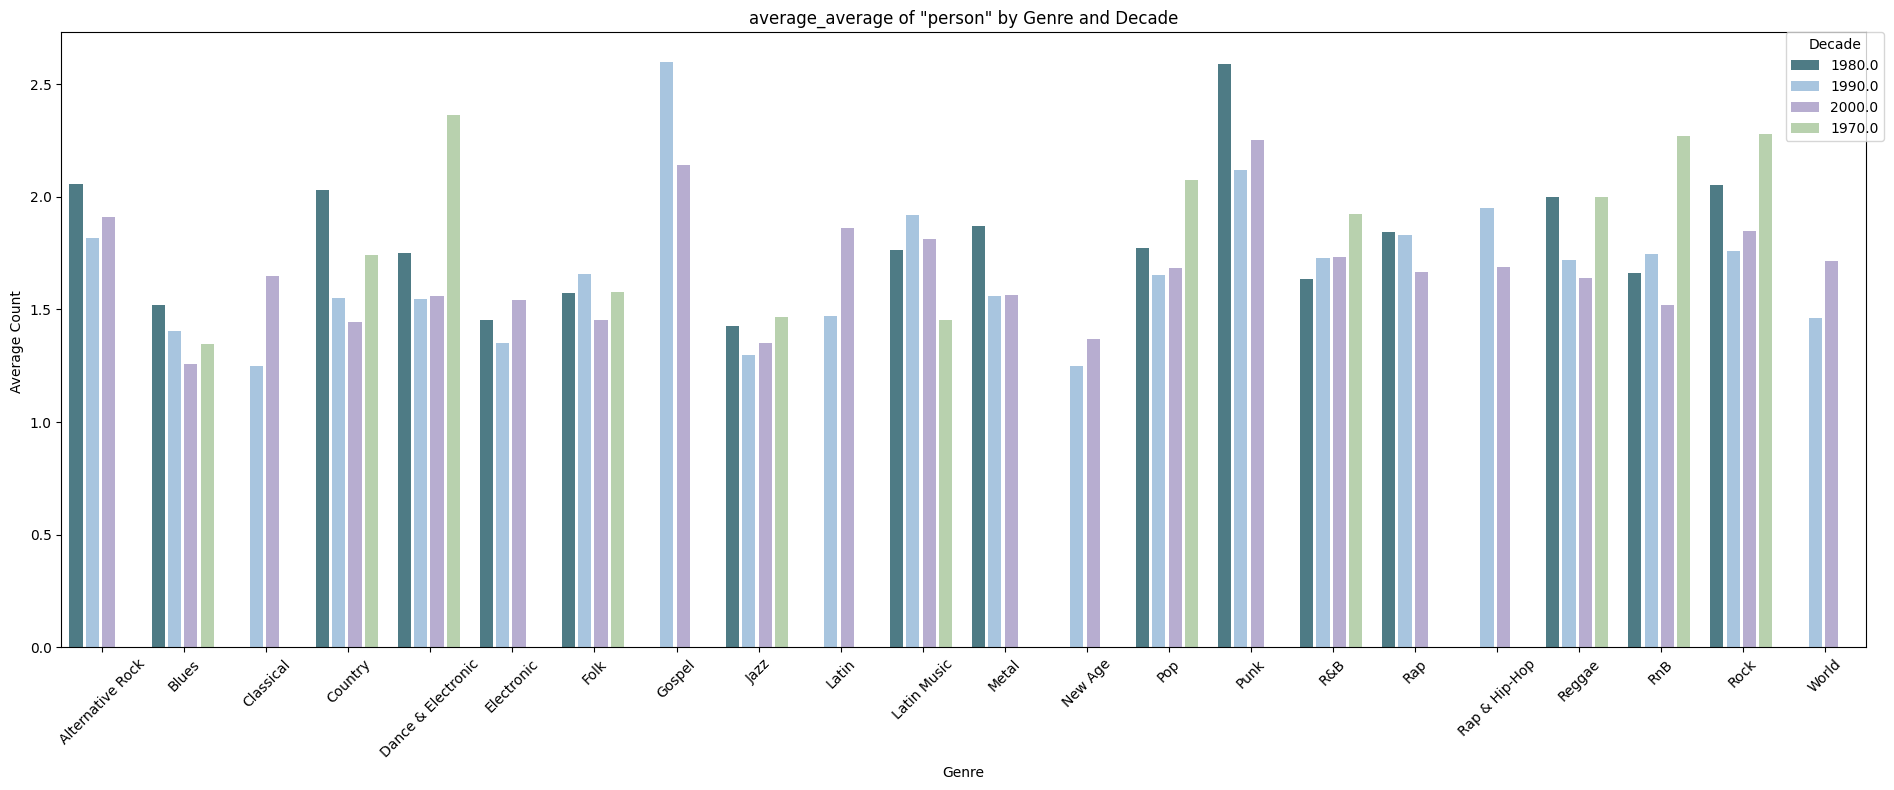

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1160974776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


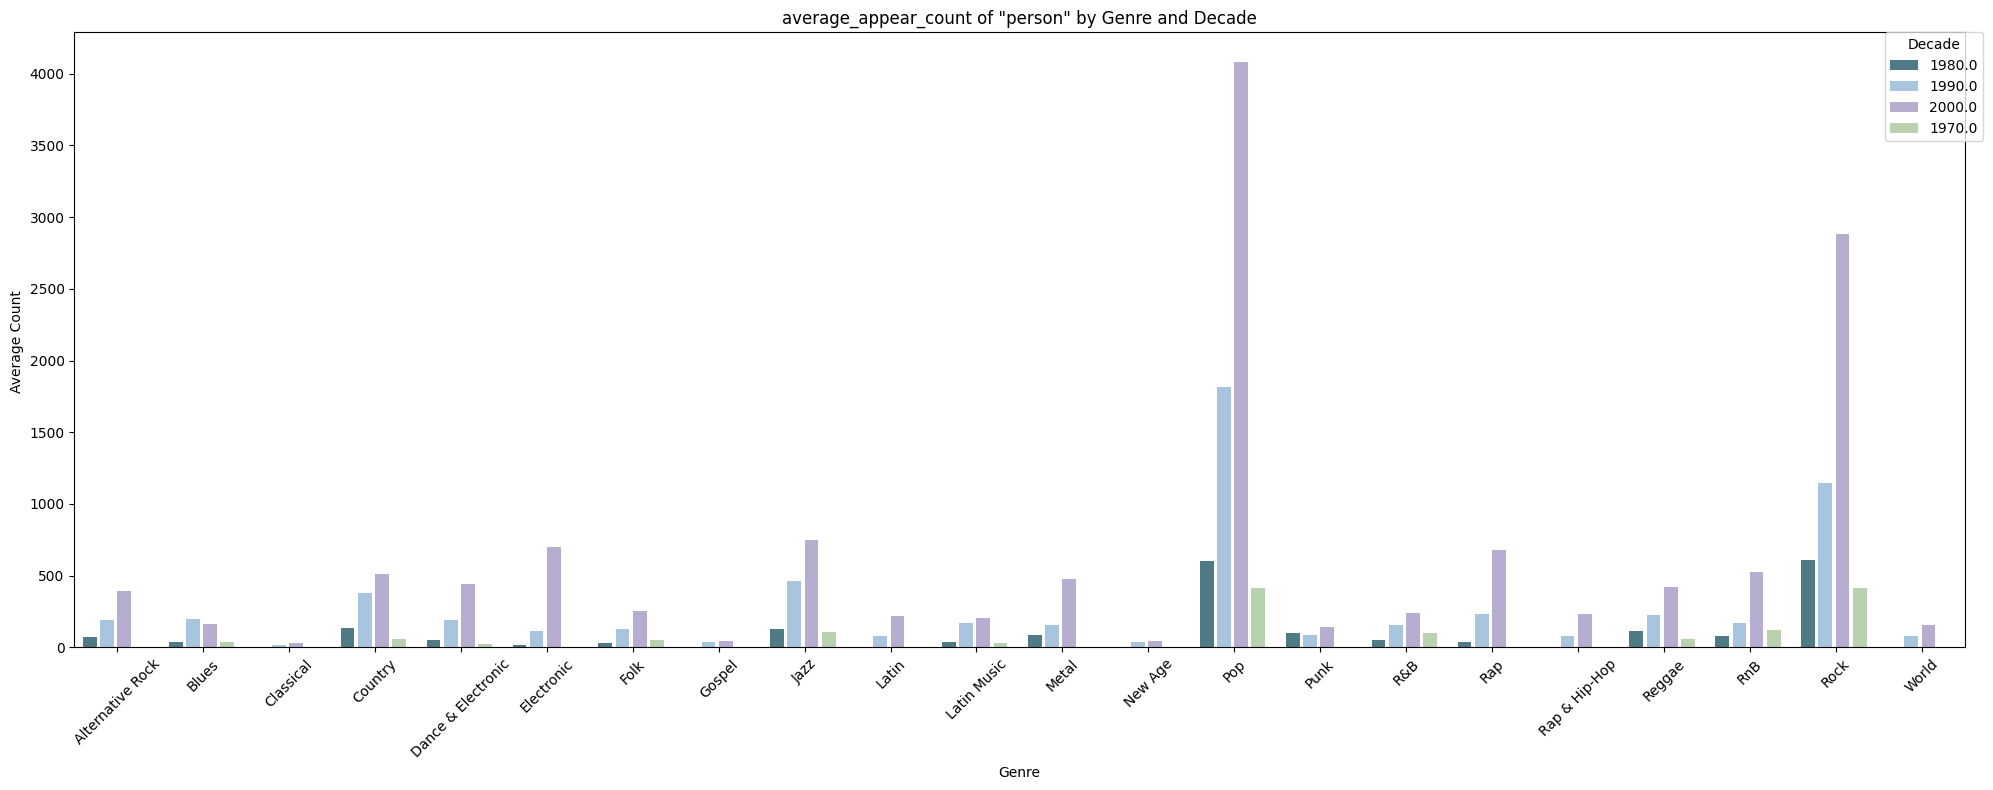

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1160974776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


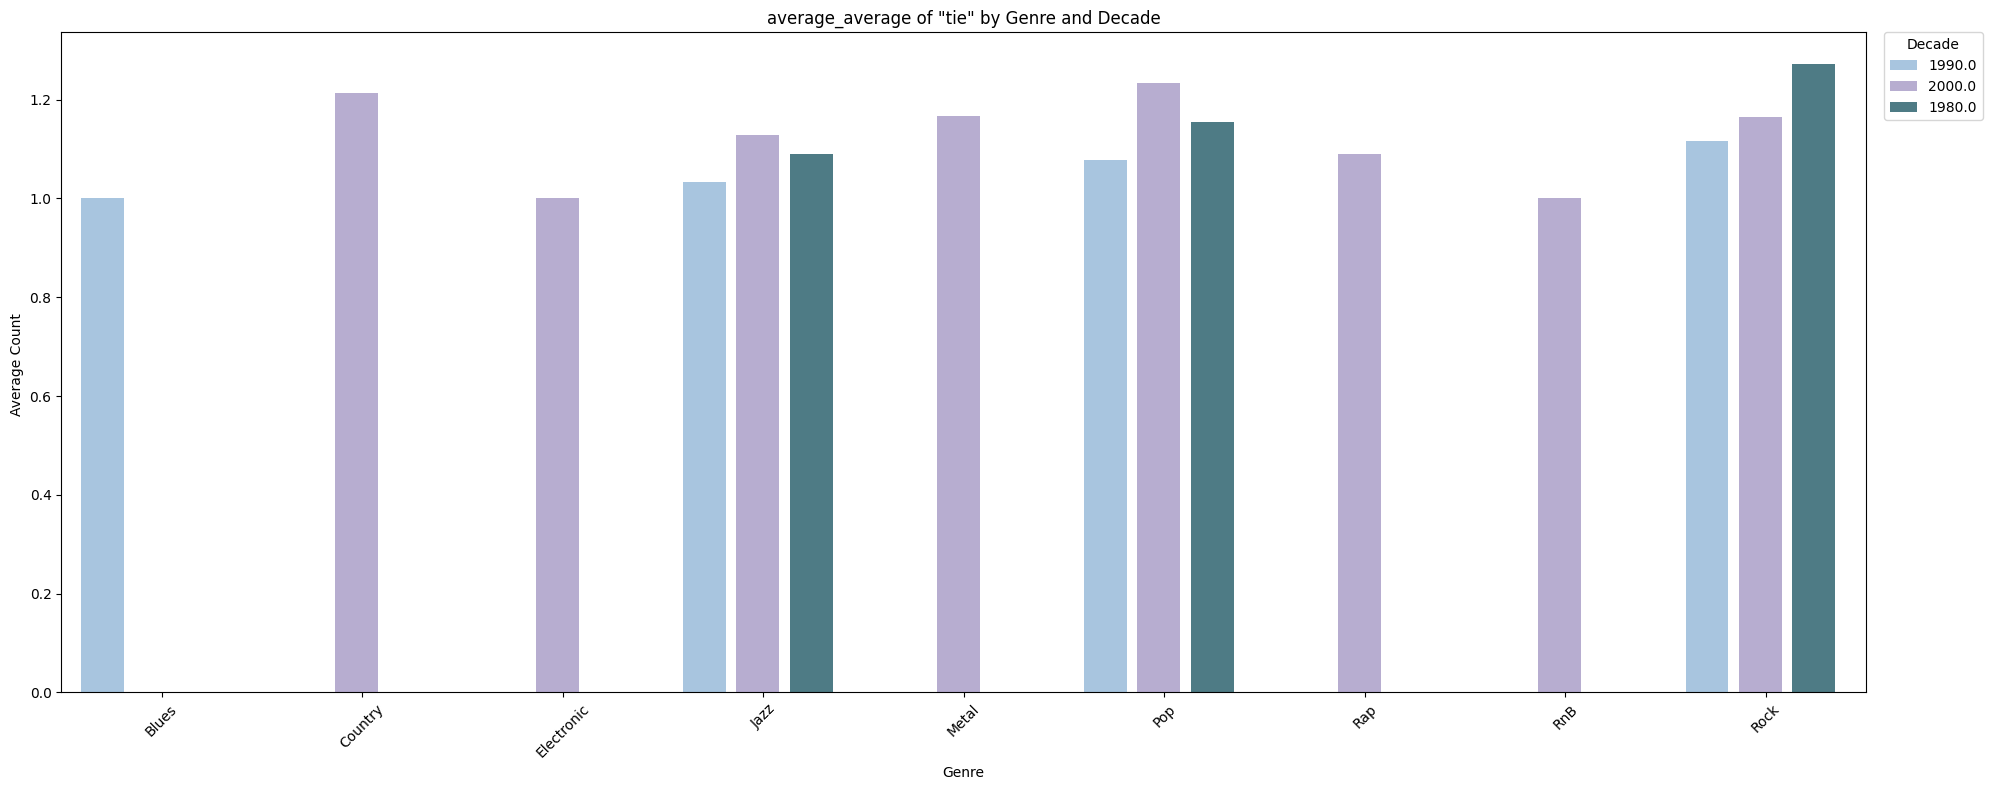

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1160974776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


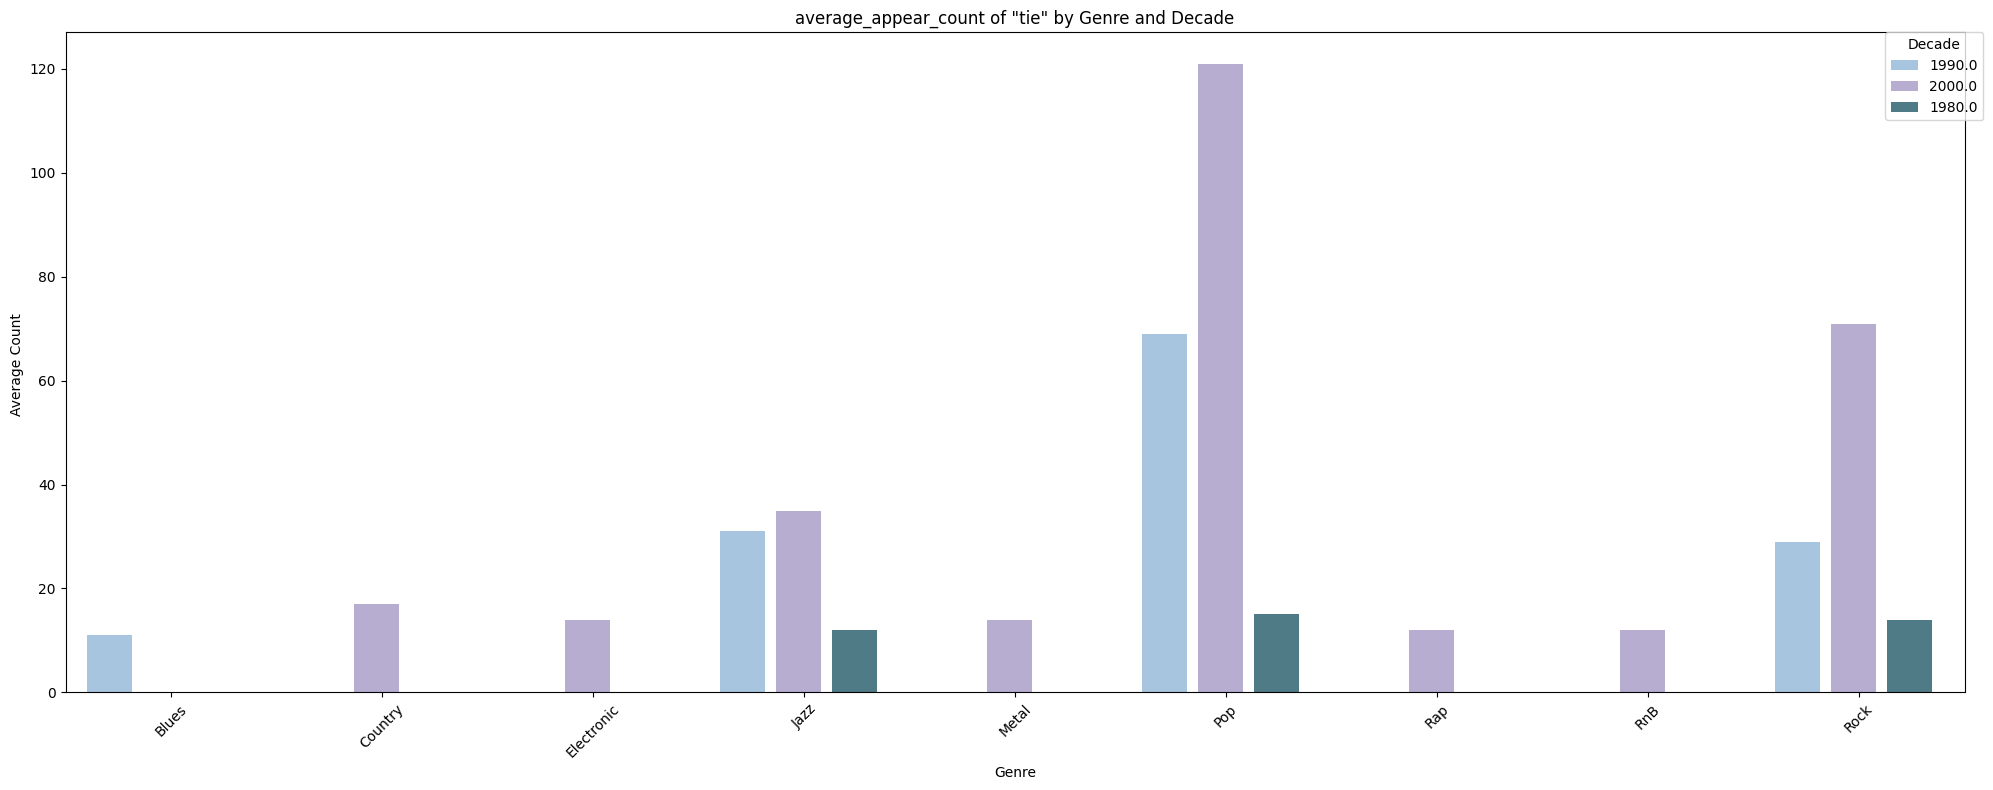

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1160974776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


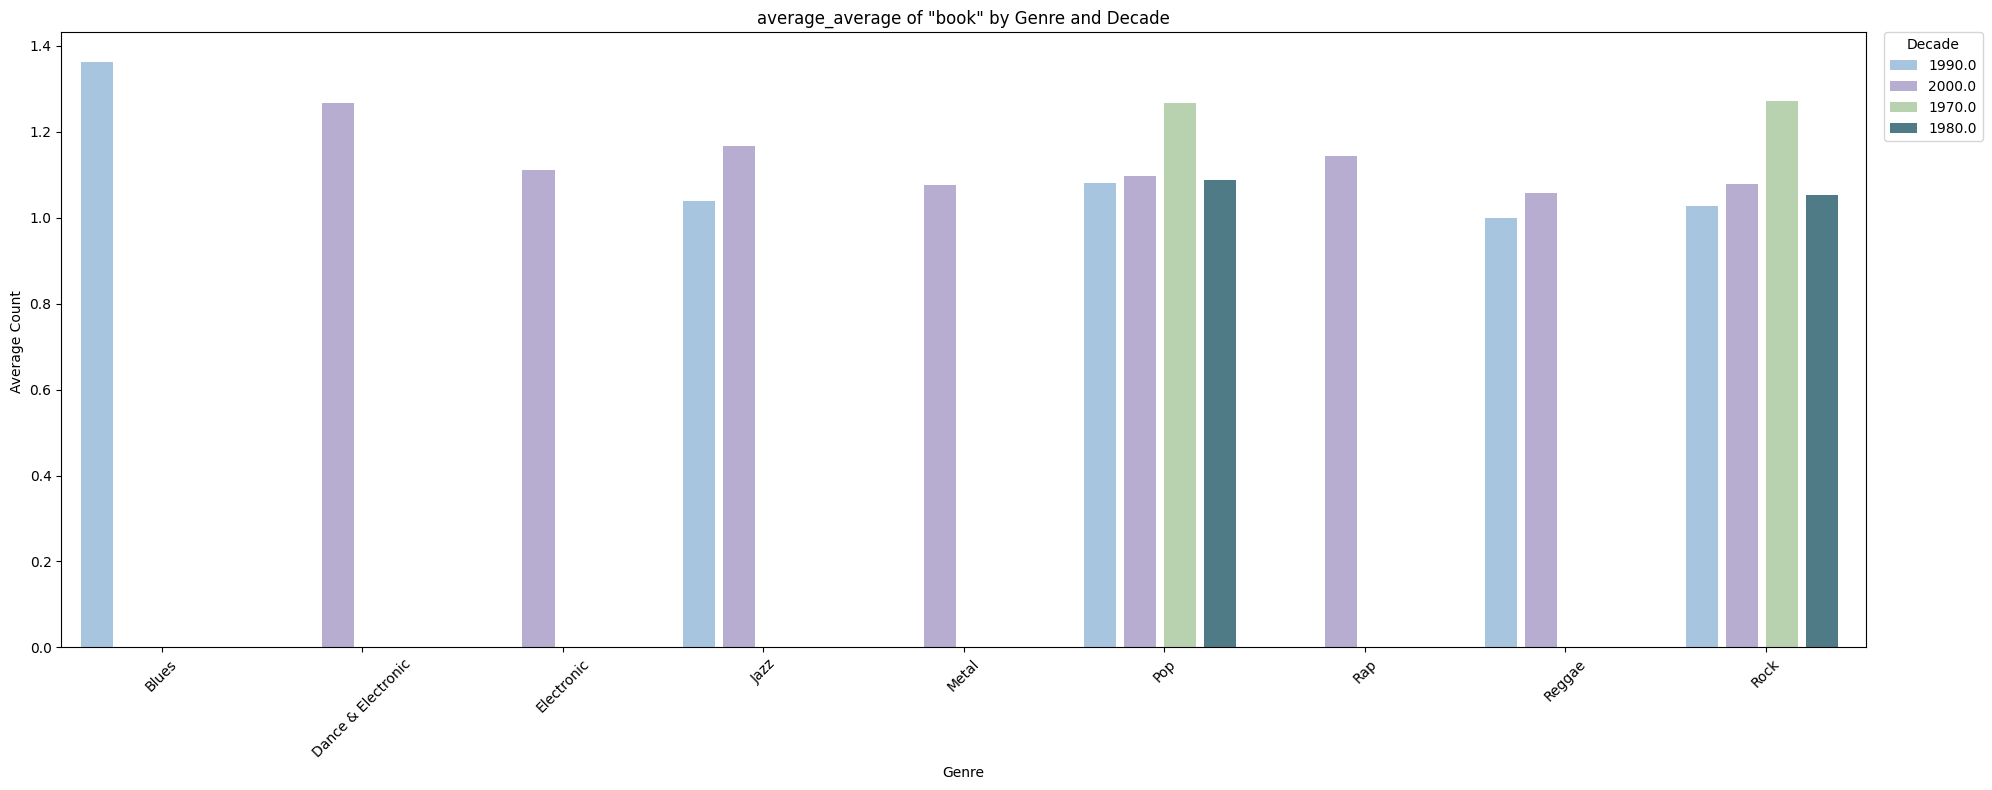

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1160974776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


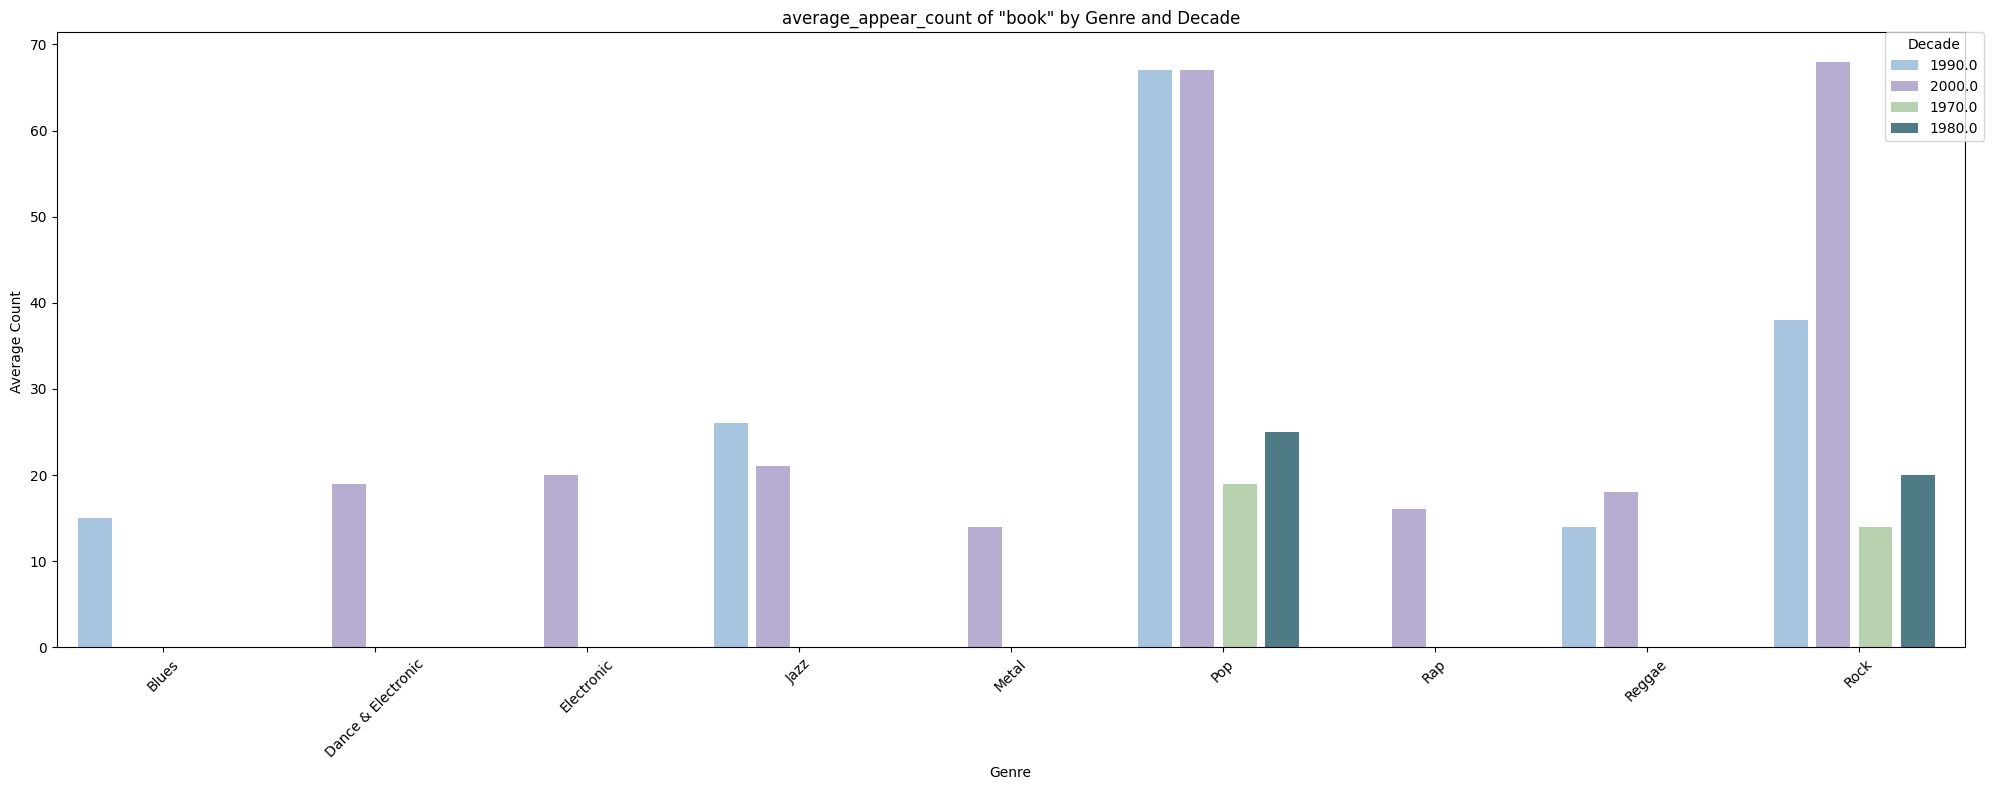

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1160974776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


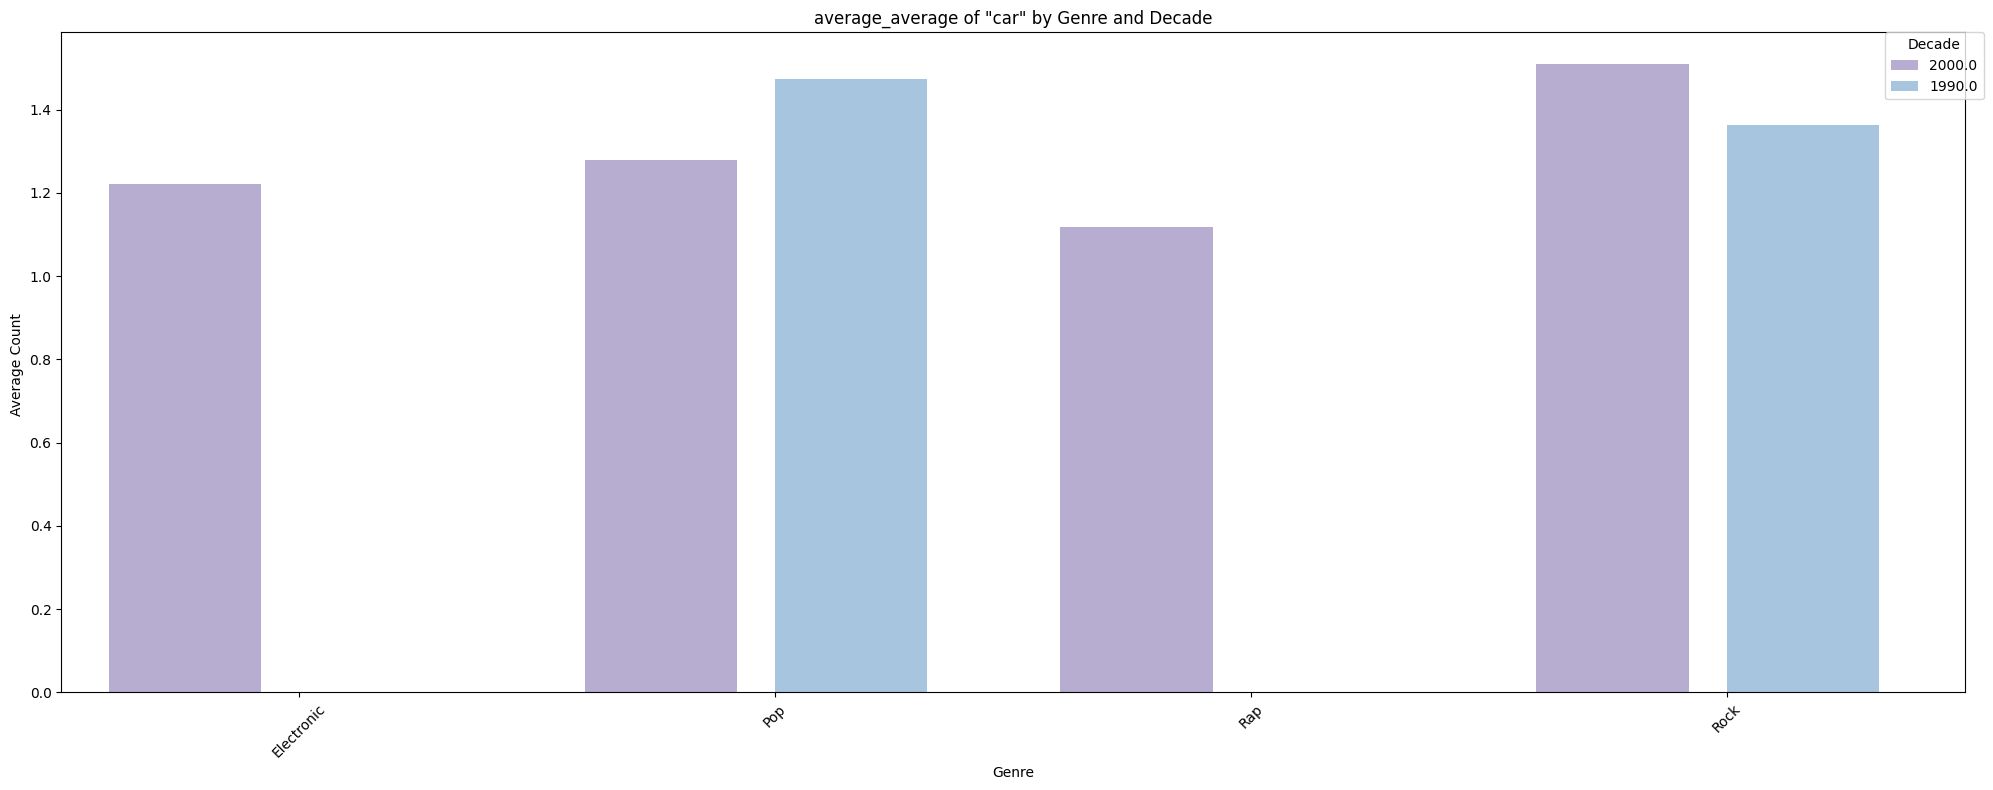

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1160974776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


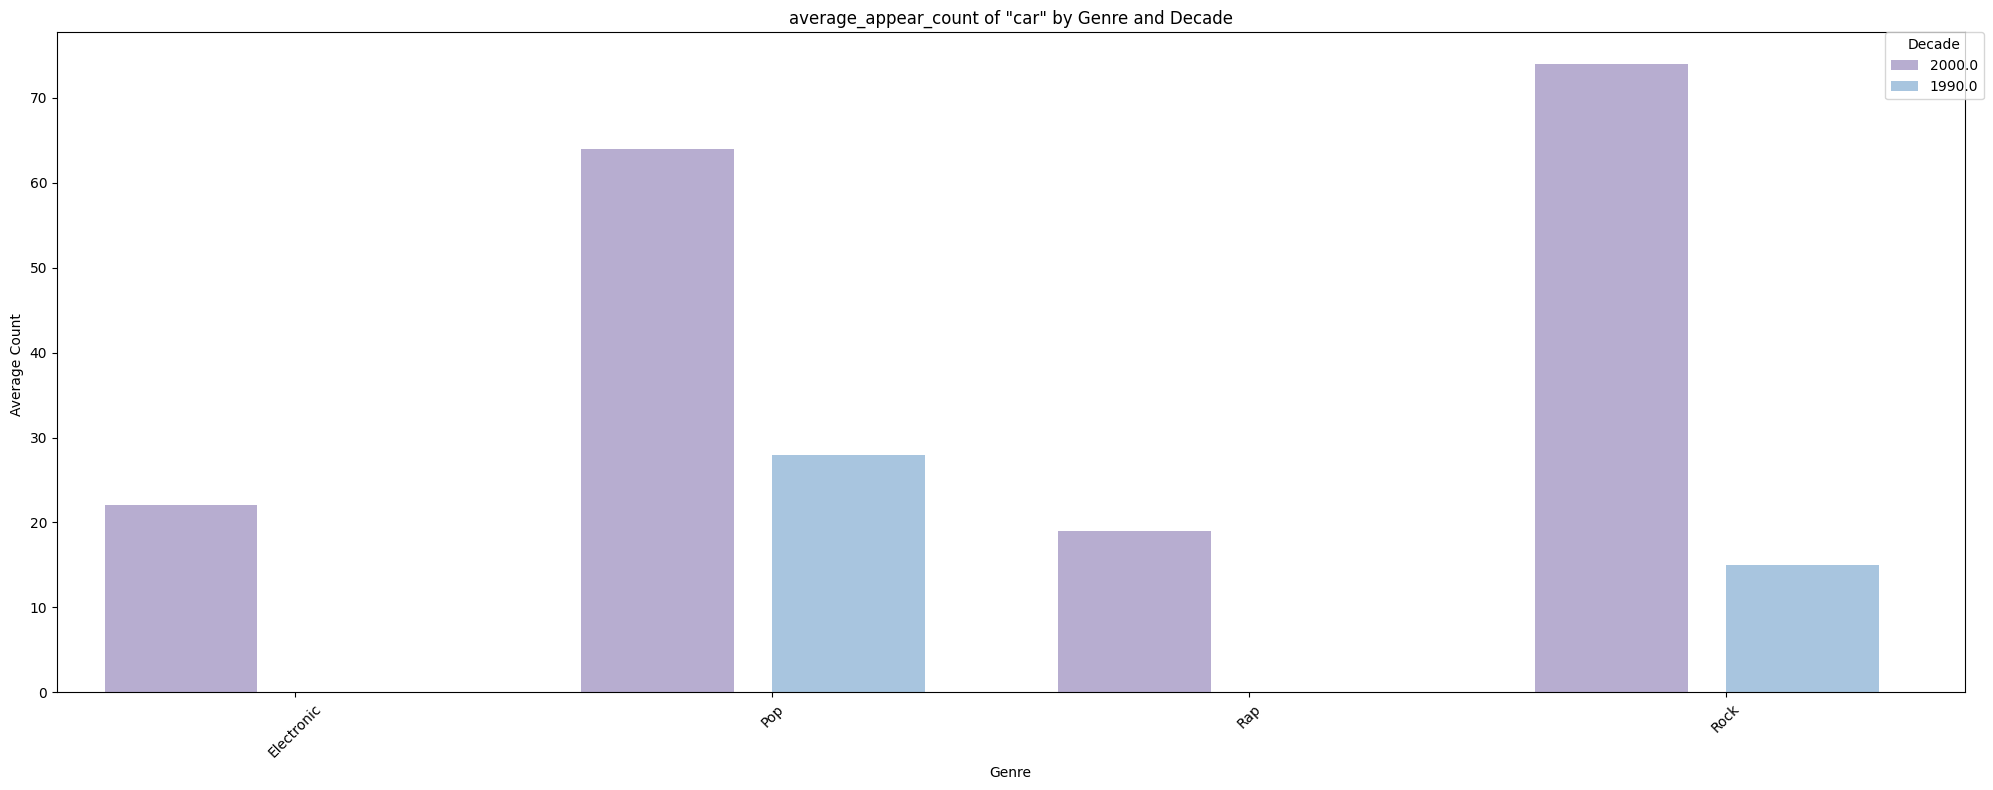

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1160974776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


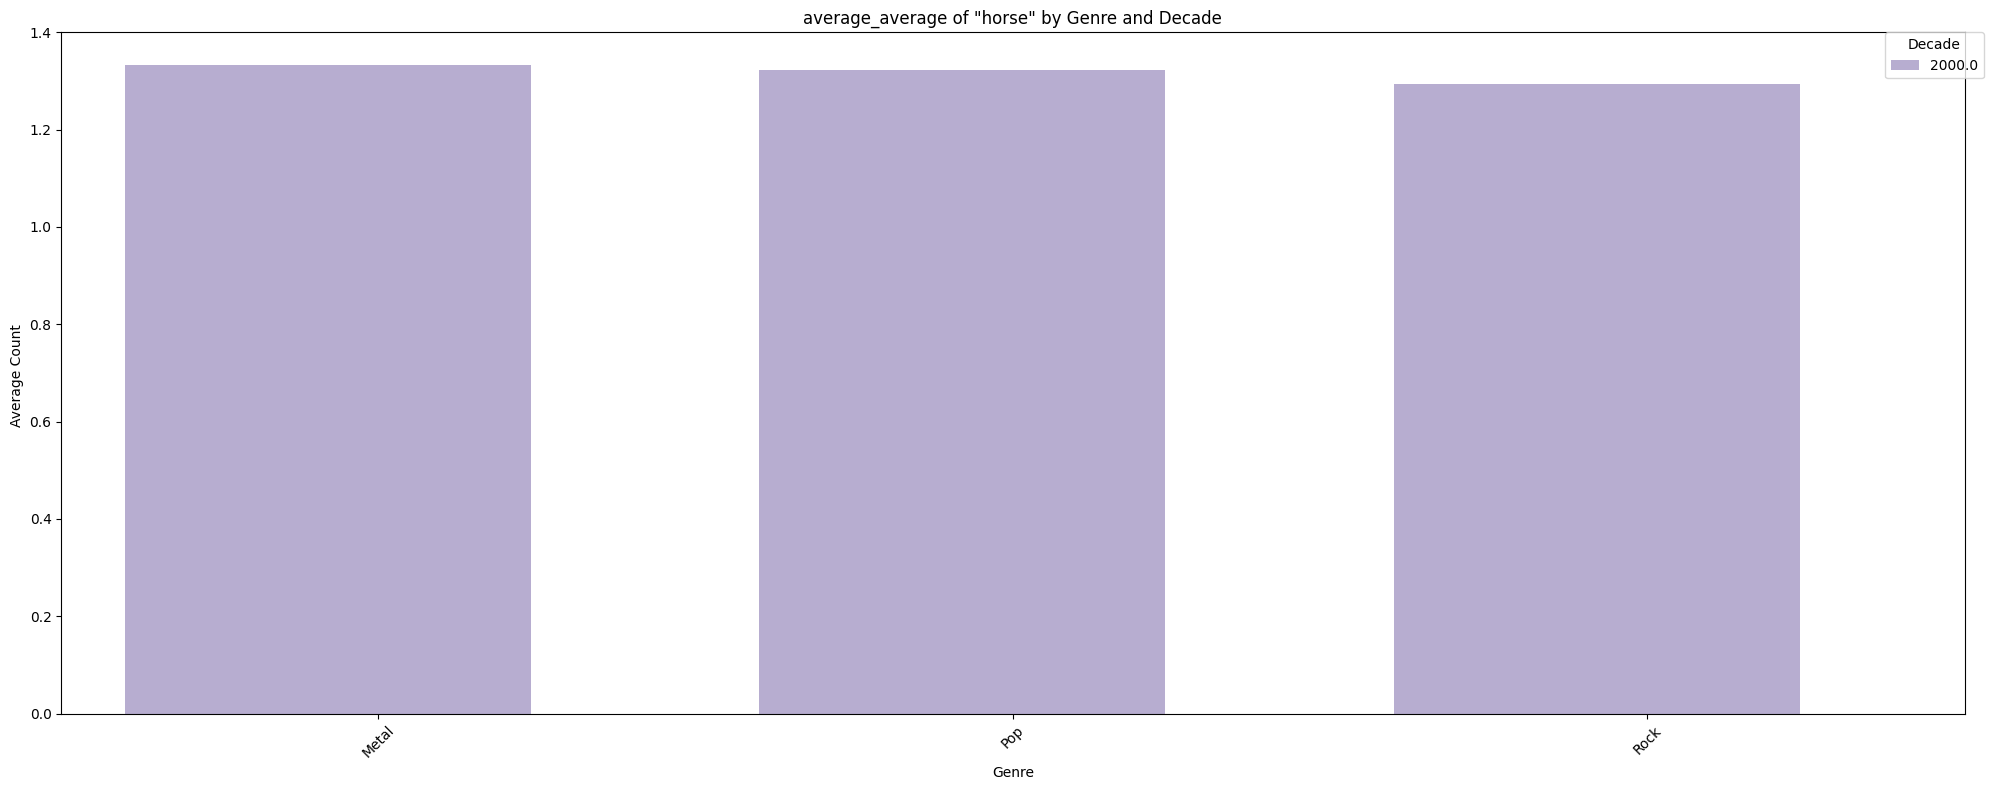

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1160974776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


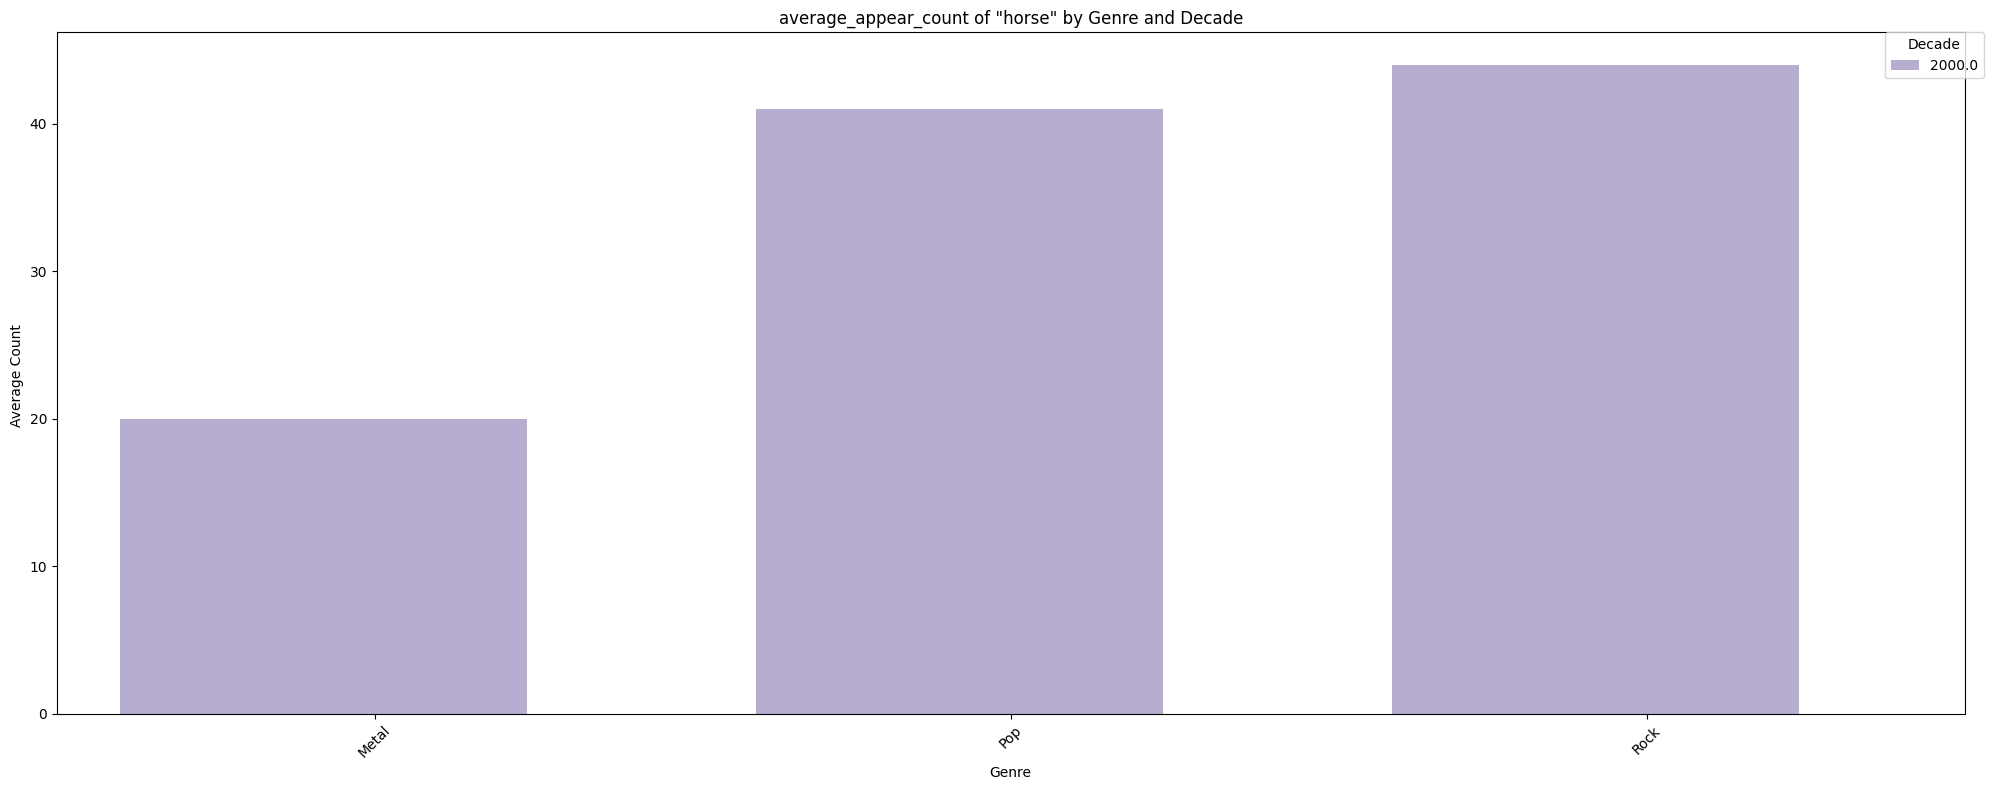

In [221]:
plot_object_distribution(average_df, 'person')
plot_object_distribution(average_df, 'person', 'average_appear_count')

plot_object_distribution(average_df, 'tie')
plot_object_distribution(average_df, 'tie', 'average_appear_count')

plot_object_distribution(average_df, 'book')
plot_object_distribution(average_df, 'book', 'average_appear_count')

plot_object_distribution(average_df, 'car')
plot_object_distribution(average_df, 'car', 'average_appear_count')

plot_object_distribution(average_df, 'horse')
plot_object_distribution(average_df, 'horse', 'average_appear_count')



## Predictions with Post processing

In [ ]:
def display_image_with_boxes_inline(row):
    # Load the image
    image_path = f"{images_path}/{row['image_name']}"
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Iterate over the predictions in the row and draw bounding boxes
    for pred in row['prediction']:
        x_center, y_center, w, h = pred['xywh']
        x_top_left, y_top_left, x_bottom_right, y_bottom_right = xywh_to_xyxy(x_center, y_center, w, h)

        label = pred['object_name']
        confidence = pred['confidence']
        label_with_conf = f'{label}: {confidence:.2f}'

        # Draw rectangle on image
        cv2.rectangle(img, (x_top_left, y_top_left), (x_bottom_right, y_bottom_right), (0, 255, 0), 2)
        
        # Put label with confidence near the bounding box
        text_x = x_top_left
        text_y = y_top_left - 10 if y_top_left - 10 > 10 else y_top_left + 20  # Adjust text position if too close to top
        cv2.putText(img, label_with_conf, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')  # Hide the axes
    plt.show()


df['image_name'] = df['prediction_results_post'].apply(lambda x: x['image_name'])
df['number_of_objects'] = df['prediction_results_post'].apply(lambda x: x['number of objects'])
df['prediction'] = df['prediction_results_post'].apply(lambda x: x['prediction'])

filtered_df = df[
    (df['m_single_genre'] == 'Blues') |
    (df['genres_mu'].fillna('').str.split(',').apply(lambda genres: 'Blues' in genres))
    ]

df_birds = filtered_df[filtered_df['unique_object_names_pos'].apply(lambda x: 'tie' in x)]

##
for index, row in df_birds[:30].iterrows():
    print(row['m_single_genre'], row['genres_mu'])
    display_image_with_boxes_inline(row)


In [232]:
objects_counts = df['num_objects_pos'].value_counts()
objects_counts_df = objects_counts.reset_index()
objects_counts_df['Percentage'] = round((objects_counts_df['count'] * 100) / len(df_final), 3)
objects_counts_df

,num_objects_pos,count,Percentage
0,0,9967,49.329
1,1,7092,35.100
2,2,1656,8.196
3,3,699,3.460
4,4,462,2.287
5,5,220,1.089
6,6,62,0.307
7,7,28,0.139
8,8,10,0.049
9,9,5,0.025


In [233]:
object_counts = (
    df['unique_object_names_pos']
    .apply(lambda x: pd.Series(x)) 
    .apply(pd.Series.value_counts, axis=1) 
    .fillna(0) 
    .astype(int)  
)

object_counts.columns = ['object_' + col for col in object_counts.columns]
df_final_unique = pd.concat([df, object_counts], axis=1)



In [235]:
unique_objects = set(x for sublist in df['unique_object_names_pos'] for x in sublist)

print(unique_objects)
print(len(unique_objects))

{'baseball glove', 'donut', 'chair', 'tv', 'teddy bear', 'wine glass', 'spoon', 'banana', 'clock', 'couch', 'dog', 'fire hydrant', 'bottle', 'mouse', 'toilet', 'knife', 'laptop', 'tennis racket', 'airplane', 'snowboard', 'vase', 'bear', 'backpack', 'apple', 'car', 'giraffe', 'surfboard', 'remote', 'frisbee', 'train', 'keyboard', 'cat', 'motorcycle', 'orange', 'baseball bat', 'bus', 'fork', 'boat', 'cake', 'carrot', 'cell phone', 'bed', 'traffic light', 'umbrella', 'skis', 'oven', 'sheep', 'potted plant', 'suitcase', 'tie', 'truck', 'elephant', 'bicycle', 'sandwich', 'zebra', 'bird', 'bowl', 'bench', 'microwave', 'horse', 'skateboard', 'scissors', 'refrigerator', 'cup', 'toothbrush', 'stop sign', 'pizza', 'cow', 'hot dog', 'book', 'handbag', 'dining table', 'sink', 'parking meter', 'kite', 'sports ball', 'person', 'broccoli'}
78


In [236]:
object_counts = {col.split('_')[1]: df_final_unique[col].sum() for col in df_final_unique.columns if col.startswith('object_')}

print(f"Number of objects individually {len(object_counts)}")


Number of objects individually 78


In [237]:
object_counts_df = pd.DataFrame(list(object_counts.items()), columns=['Object', 'Count'])
object_counts_df_sorted = object_counts_df.sort_values('Count', ascending=False)
object_counts_df_sorted.reset_index(drop=True, inplace=True)
object_counts_df_sorted['Percentage'] = round((object_counts_df_sorted['Count'] * 100) / object_counts_df_sorted['Count'].sum(), 3)

object_counts_df_sorted[:11] #

,Object,Count,Percentage
0,person,9042,79.358
1,tie,247,2.168
2,book,192,1.685
3,tv,180,1.580
4,car,154,1.352
5,bird,120,1.053
6,clock,113,0.992
7,chair,112,0.983
8,dog,105,0.922
9,horse,96,0.843


In [238]:
 object_counts_df_sorted['Count'].sum()

11394

In [ ]:
average = []
for genre in unique_genre:
    for decade in unique_decades:
        print(genre, decade)
        average.append(get_average_object(df, decade, genre, True))

In [251]:
for genre in unique_genre:
    to_save_df = df[
    (df['m_single_genre'] == genre) |
    (df['genres_mu'].fillna('').str.split(',').apply(lambda genres: genre in genres))
    ]
    save_directory = f"saved_images_pos/{genre}"
    
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    # Save the first 10 images with bounding boxes
    for index, row in to_save_df[:50].iterrows():
        save_image_name = os.path.join(save_directory, os.path.basename(row['image_name']))
        save_image_with_boxes(row, save_image_name, 'prediction_pos')


In [252]:
average_df = pd.json_normalize(average, 'Average', ['decade', 'genre', 'number_of_rows'], 
                       record_prefix='average_', errors='ignore')



In [253]:
average_df[(average_df['genre'] == 'Gospel') 
            ]

,average_object,average_average,average_appear_count,average_row_count,average_percentage,decade,genre,number_of_rows
24,person,2.083333,25,12,63.157895,1990.0,Gospel,19
25,person,1.888889,34,18,81.818182,2000.0,Gospel,22


In [254]:

unique_genre = sorted(average_df['genre'].dropna().unique())

top_stats = []

for genre in unique_genre:
    filtered_df = average_df[average_df['genre'] == genre]
    
    for decade in unique_decades:
        decade_df = filtered_df[filtered_df['decade'] == decade]
        
        top_rows = decade_df.nlargest(3, 'average_percentage')
        
        for rank, (index, row) in enumerate(top_rows.iterrows(), start=1):
            top_stats.append({
                "genre": genre,
                "decade": decade,
                "rank": rank,
                "object": row['average_object'],  # Replace with your actual column name if different
                "average": row['average_average'],  # Replace with your actual column name if different
                "percentage": row['average_percentage']  # Replace with your actual column name if different
            })

top_stats_df = pd.DataFrame(top_stats)


In [255]:
 top_stats_df[top_stats_df['rank'] == 2][:40]

,genre,decade,rank,object,average,percentage
17,Electronic,2000.0,2,tv,1.000000,0.917993
28,Jazz,1990.0,2,tie,1.062500,2.605863
30,Jazz,2000.0,2,tie,1.055556,2.083333
41,Metal,2000.0,2,bird,1.368421,1.603376
46,Pop,1970.0,2,book,1.181818,3.363914
48,Pop,1980.0,2,book,1.090909,1.929825
50,Pop,1990.0,2,tie,1.057143,1.955307
53,Pop,2000.0,2,tie,1.218182,1.424501
78,Rock,1990.0,2,tie,1.117647,1.107492
81,Rock,2000.0,2,bird,1.432432,0.990099


In [257]:

unique_object = sorted(average_df['average_object'].dropna().unique())

average_object_stats = []
for object in unique_object:
    filtered_df = average_df[
            (average_df['average_object'] == object) 
            ]
    max_average_index = filtered_df['average_percentage'].idxmax()
    min_average_index = filtered_df['average_percentage'].idxmin()
    # Get the row with the maximum 'average_average' value
    max_average_row = filtered_df.loc[max_average_index]
    min_average_row = filtered_df.loc[min_average_index]

    average_object_stats.append({
                            "object" : object,
                            "max_genre": max_average_row.genre,
                            "max_decade": max_average_row.decade,
                            "max_average" : max_average_row.average_average,
                            "max_percentage" : max_average_row.average_percentage,
                            "min_genre": min_average_row.genre,
                            "min_decade": min_average_row.decade,
                            "min_average" : min_average_row.average_average,
                            "min_percentage" : min_average_row.average_percentage,
                        })



In [258]:
average_object_stats_df = pd.DataFrame(average_object_stats)
average_object_stats_df

,object,max_genre,max_decade,max_average,max_percentage,min_genre,min_decade,min_average,min_percentage
0,bed,Pop,2000.0,1.076923,0.336700,Rock,2000.0,1.000000,0.321113
1,bird,Metal,2000.0,1.368421,1.603376,Pop,2000.0,1.777778,0.466200
2,book,Pop,1970.0,1.181818,3.363914,Pop,2000.0,1.166667,0.621601
3,car,Rock,2000.0,1.352941,0.909821,Pop,1990.0,1.454545,0.614525
4,chair,Pop,1990.0,1.000000,0.726257,Rock,2000.0,1.600000,0.535189
5,clock,Metal,2000.0,1.062500,1.350211,Pop,2000.0,1.187500,0.414400
6,dog,Rock,1990.0,1.000000,0.846906,Rock,2000.0,1.125000,0.428151
7,horse,Pop,2000.0,1.217391,0.595701,Rock,2000.0,1.263158,0.508429
8,kite,Rock,2000.0,1.076923,0.347873,Rock,2000.0,1.076923,0.347873
9,motorcycle,Pop,2000.0,1.250000,0.310800,Pop,2000.0,1.250000,0.310800


/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1898802879.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


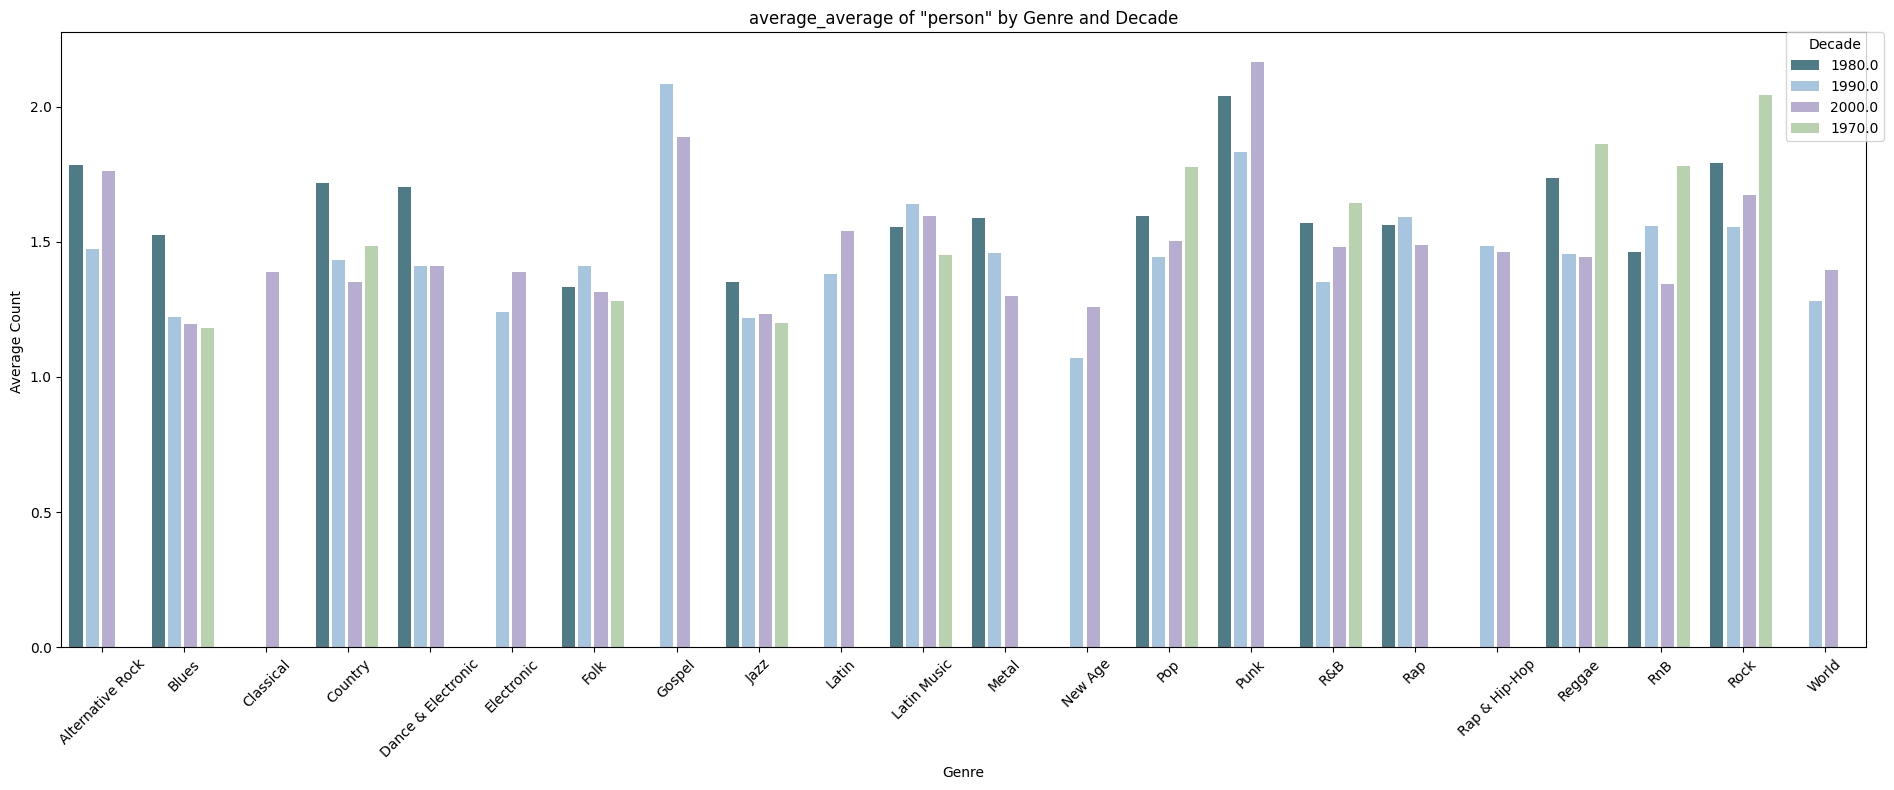

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1898802879.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


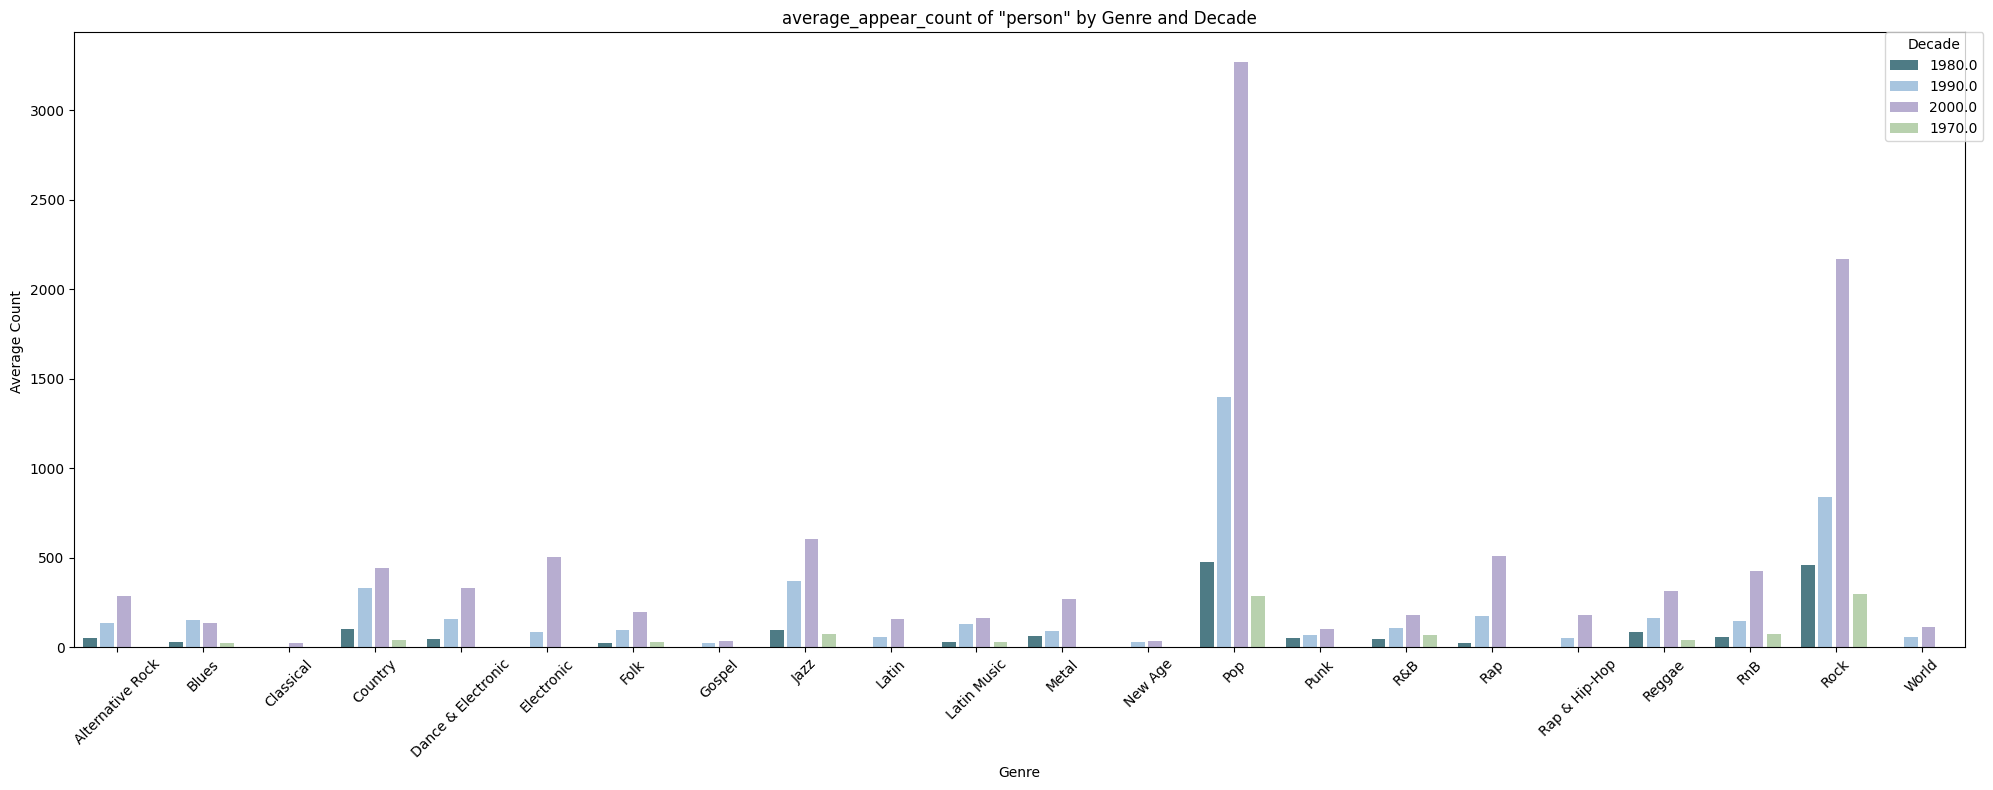

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1898802879.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


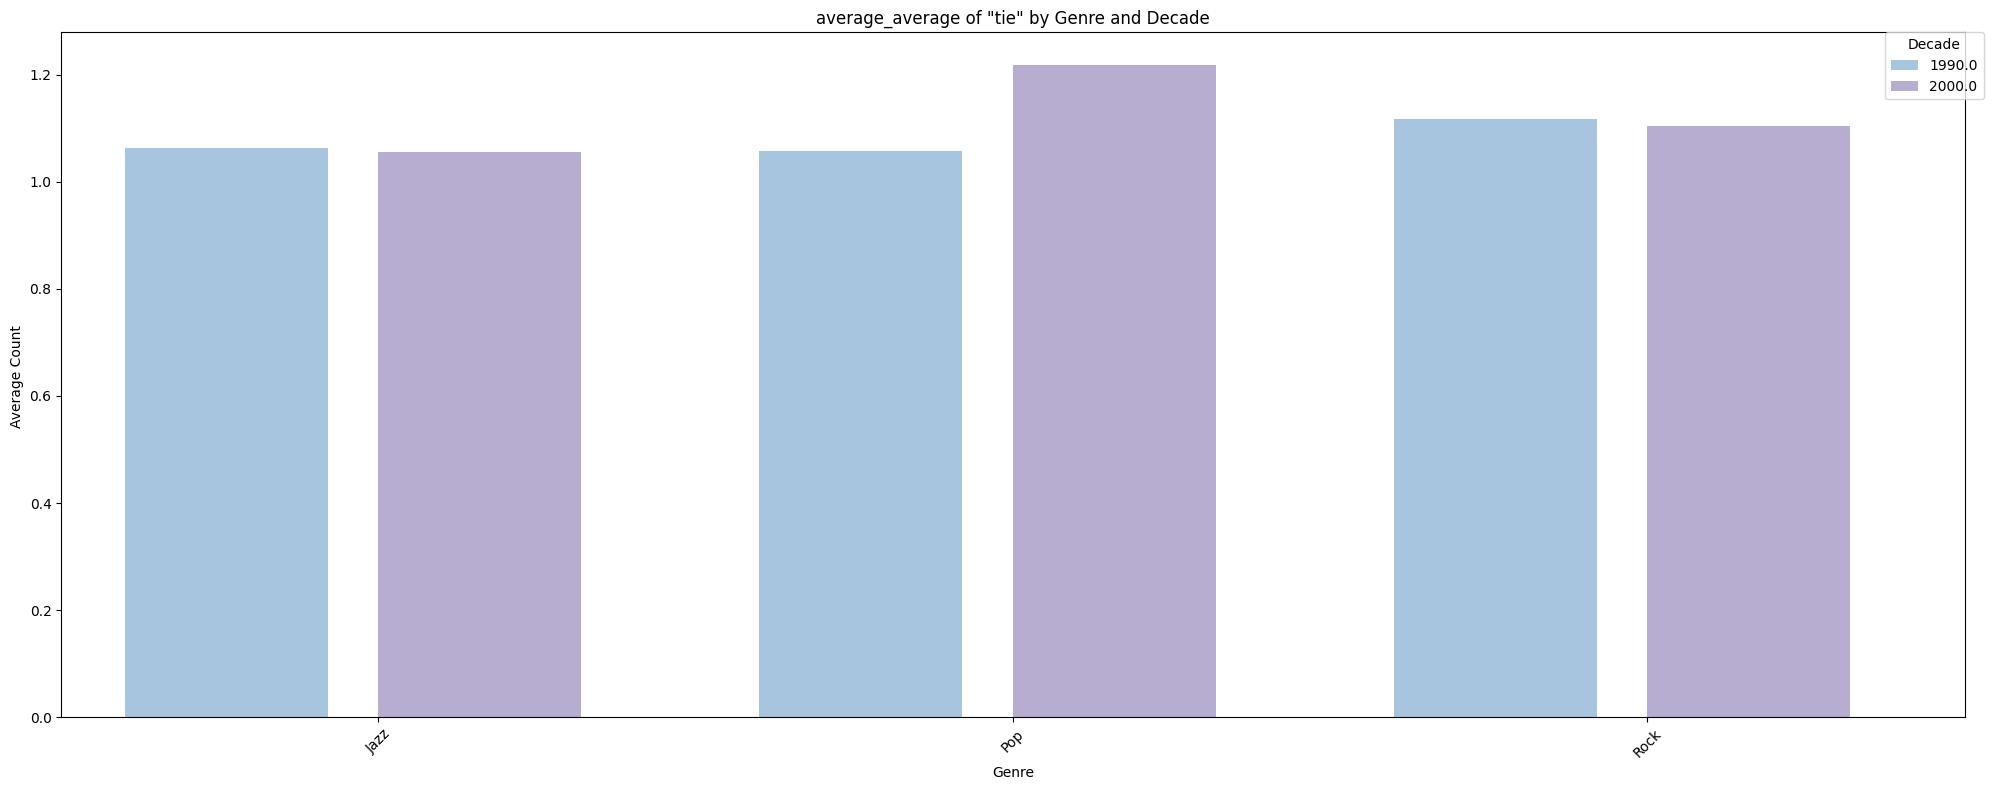

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1898802879.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


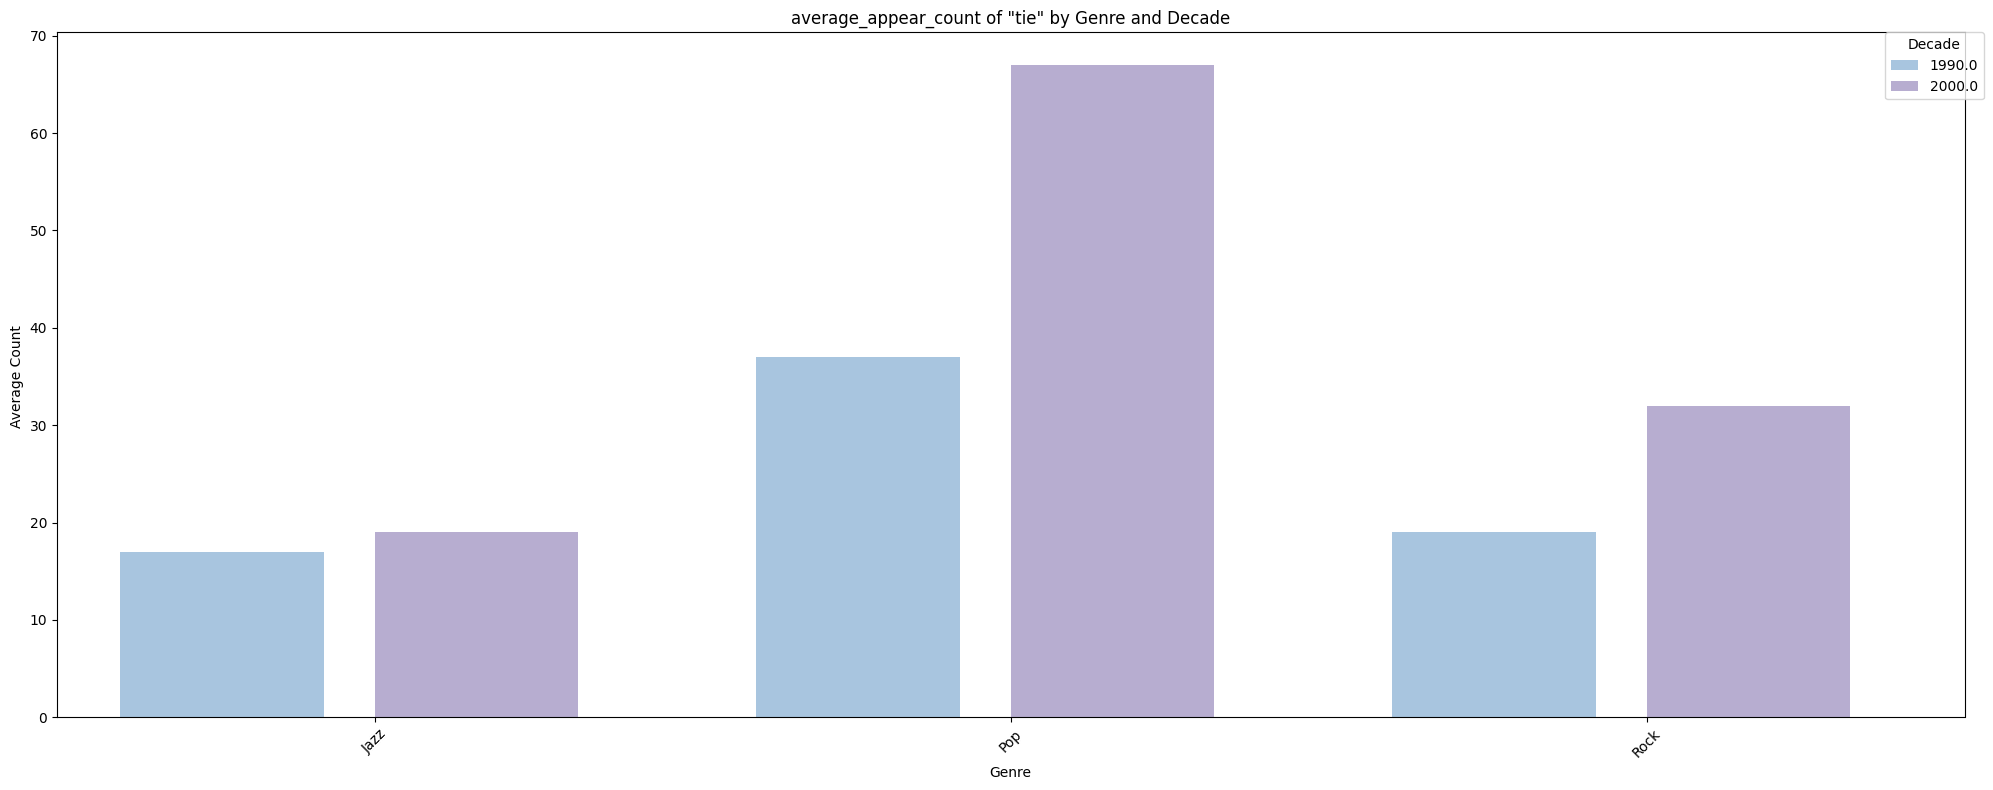

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1898802879.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


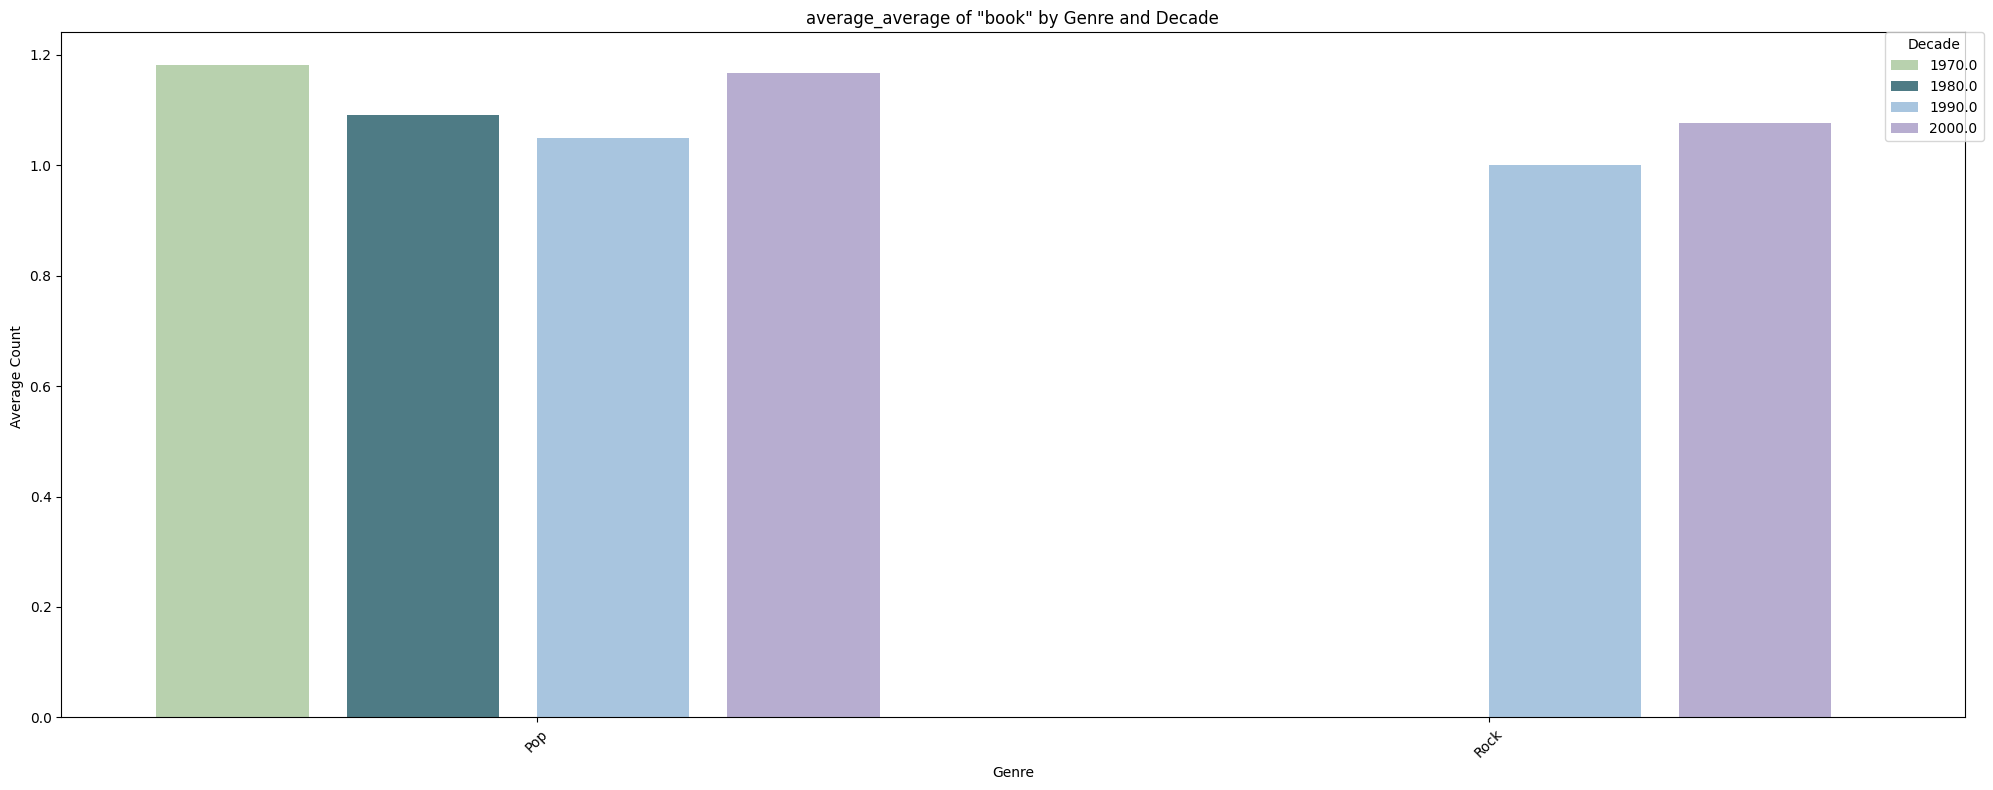

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1898802879.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


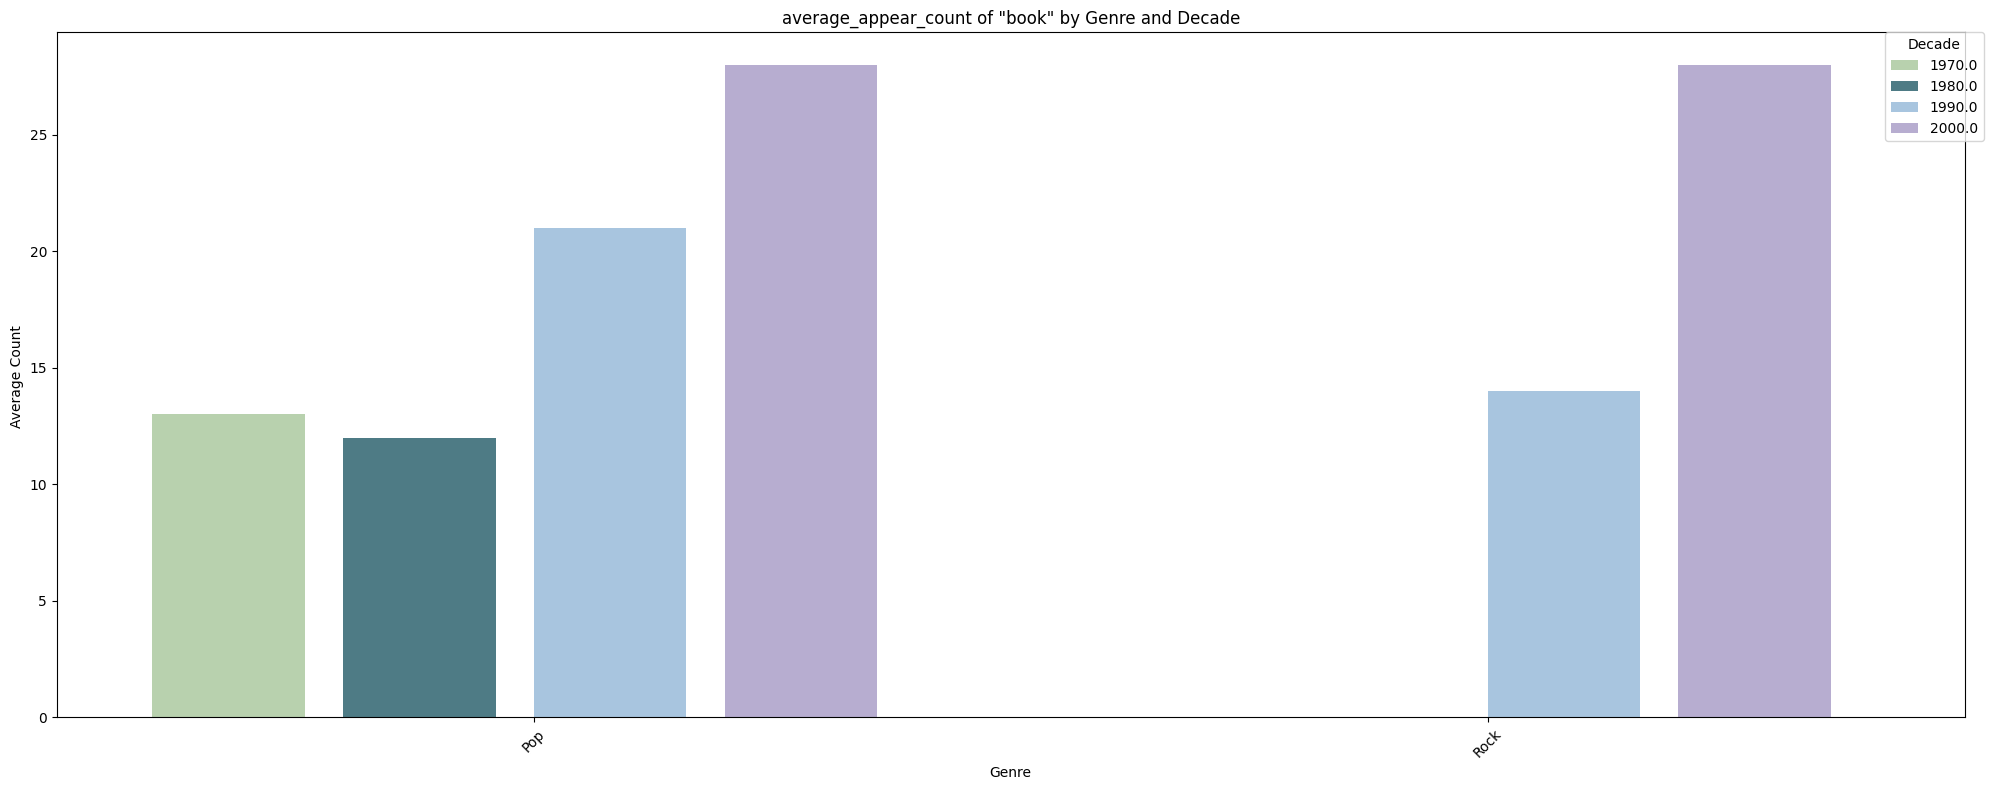

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1898802879.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


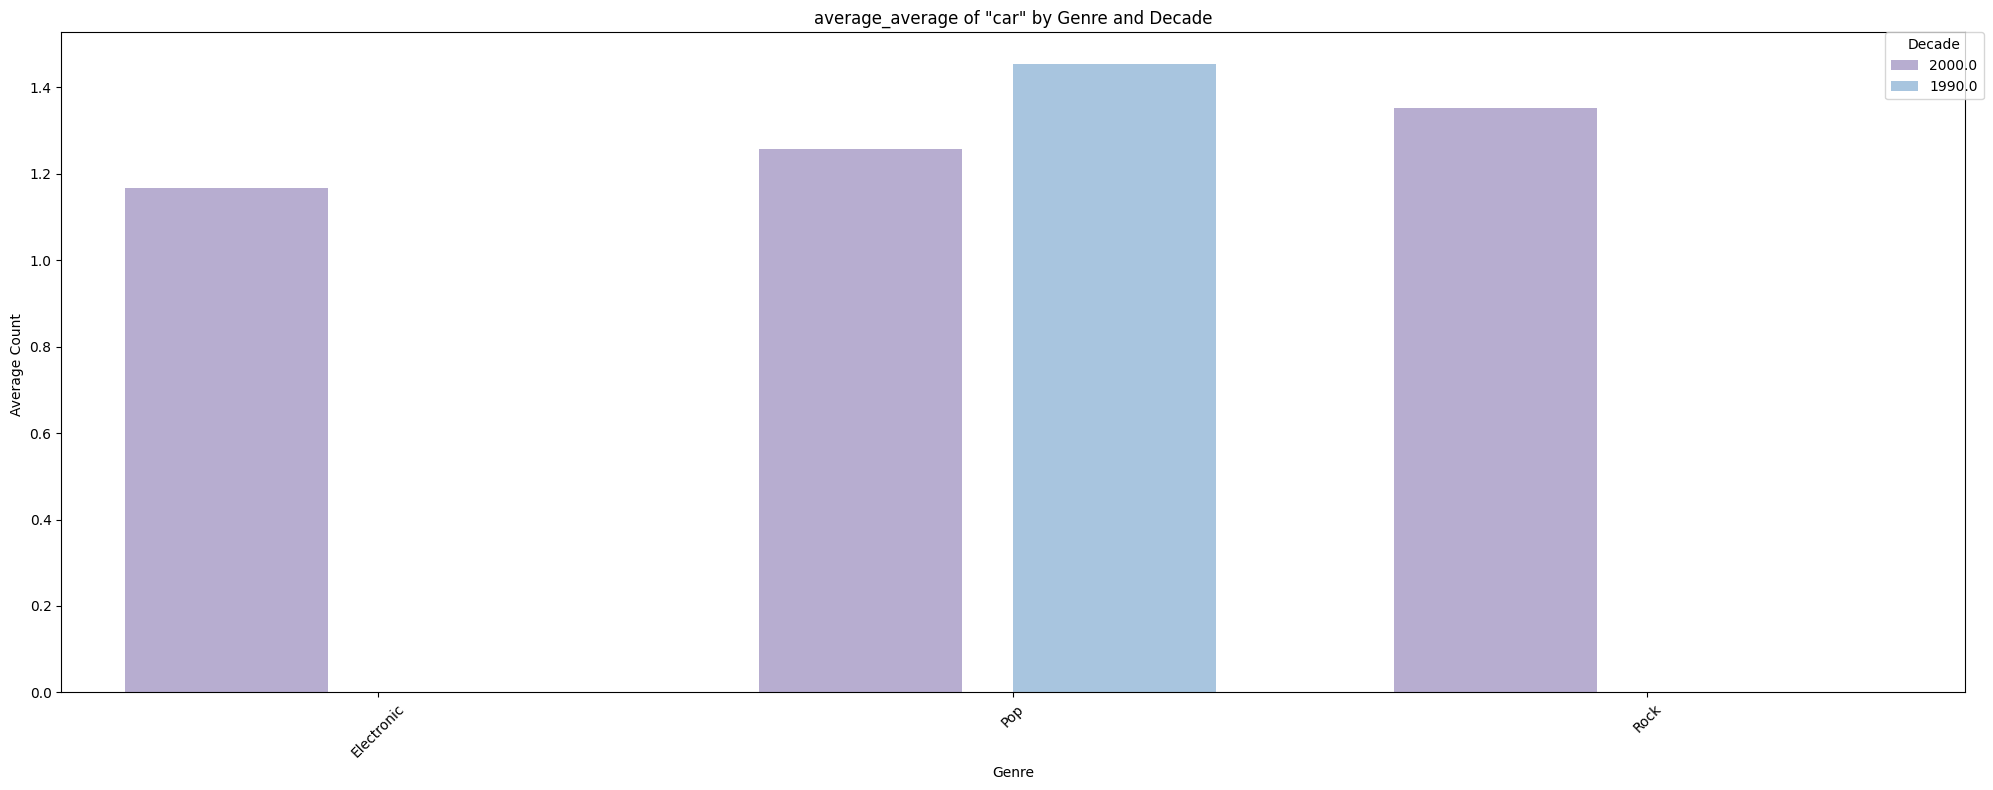

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1898802879.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


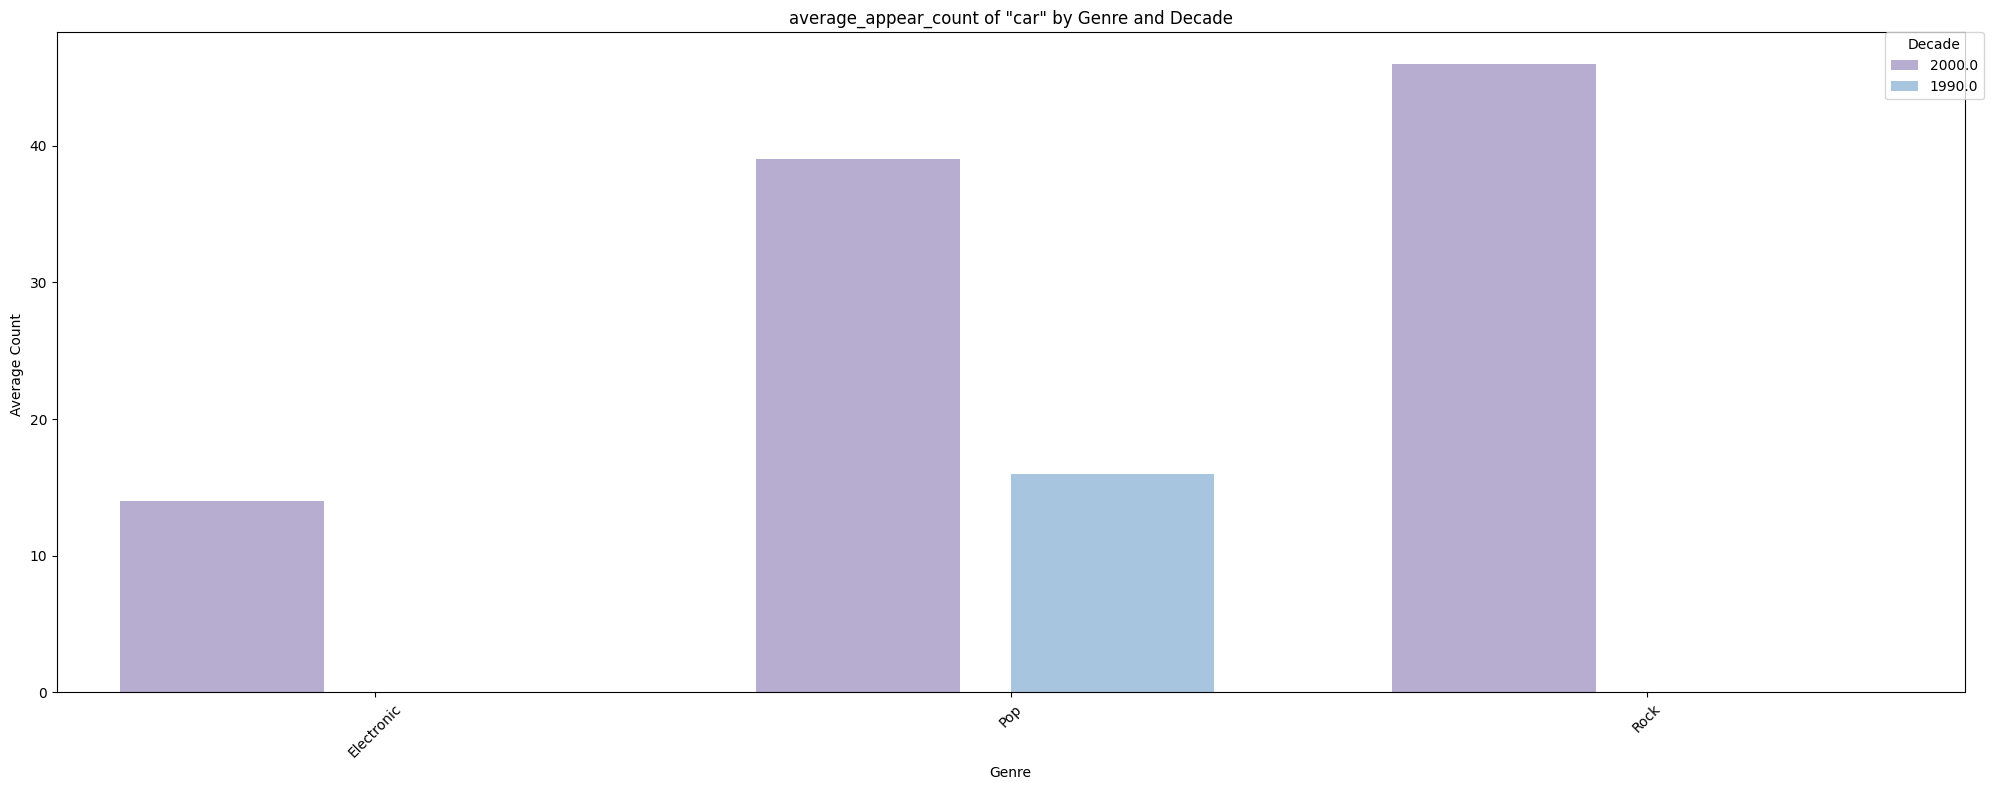

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1898802879.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


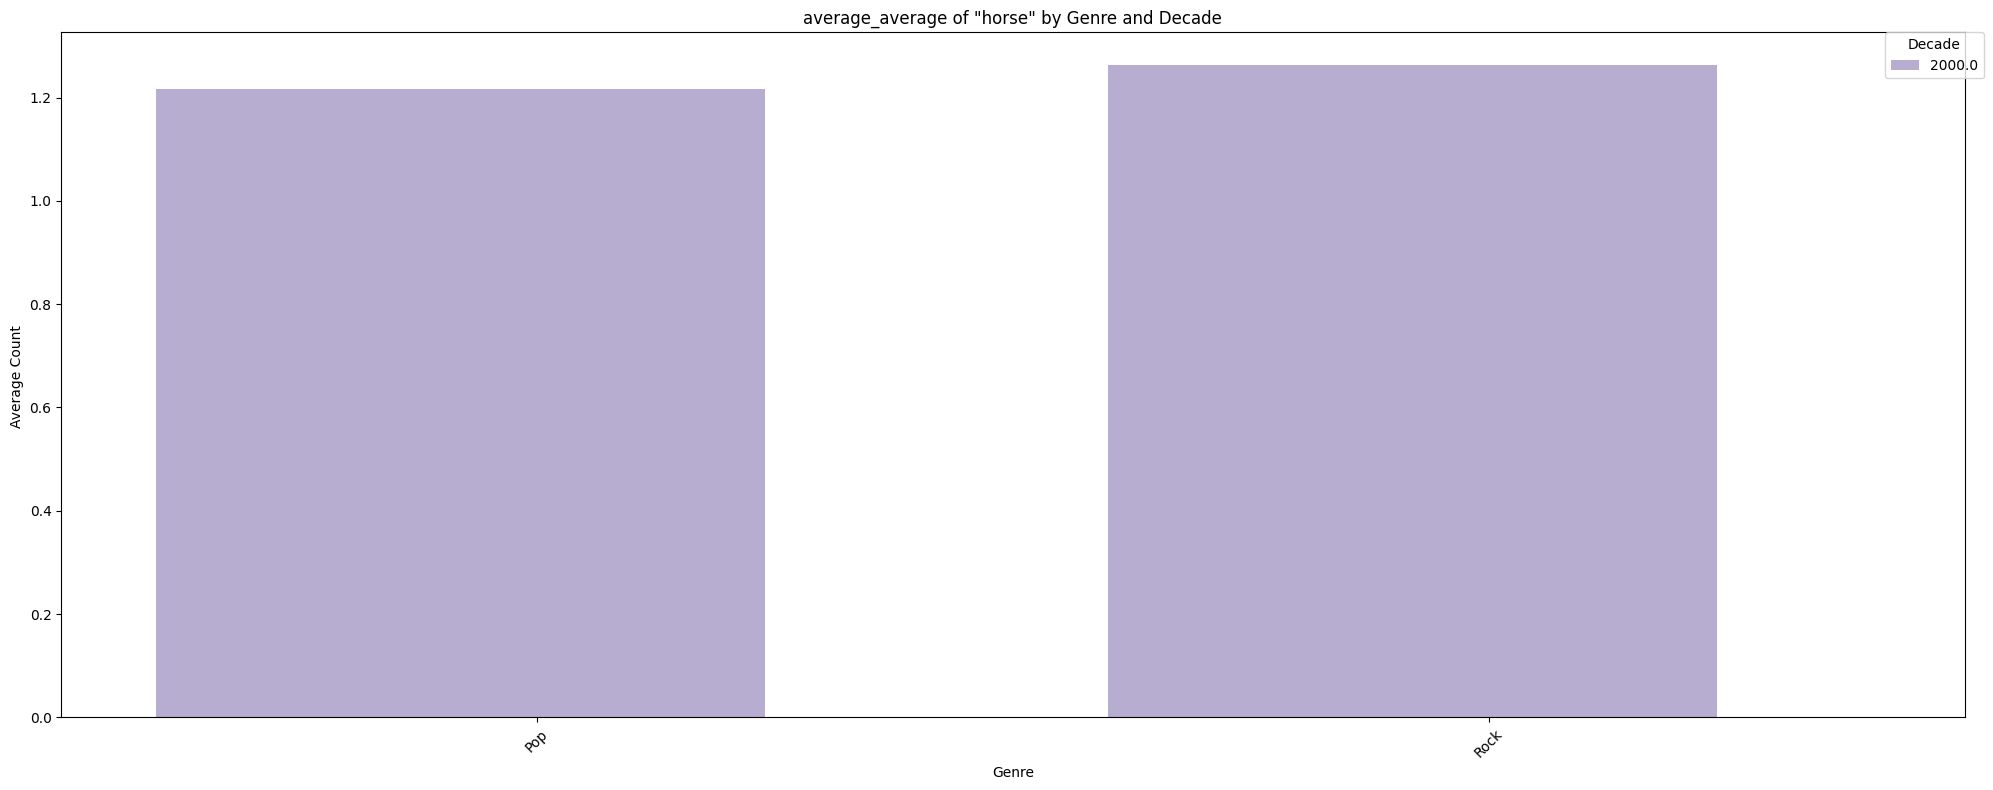

/var/folders/00/6v4ypdjx7mlb7kcwyj2mg58m0000gn/T/ipykernel_21872/1898802879.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = filtered_df['decade'].astype(str)


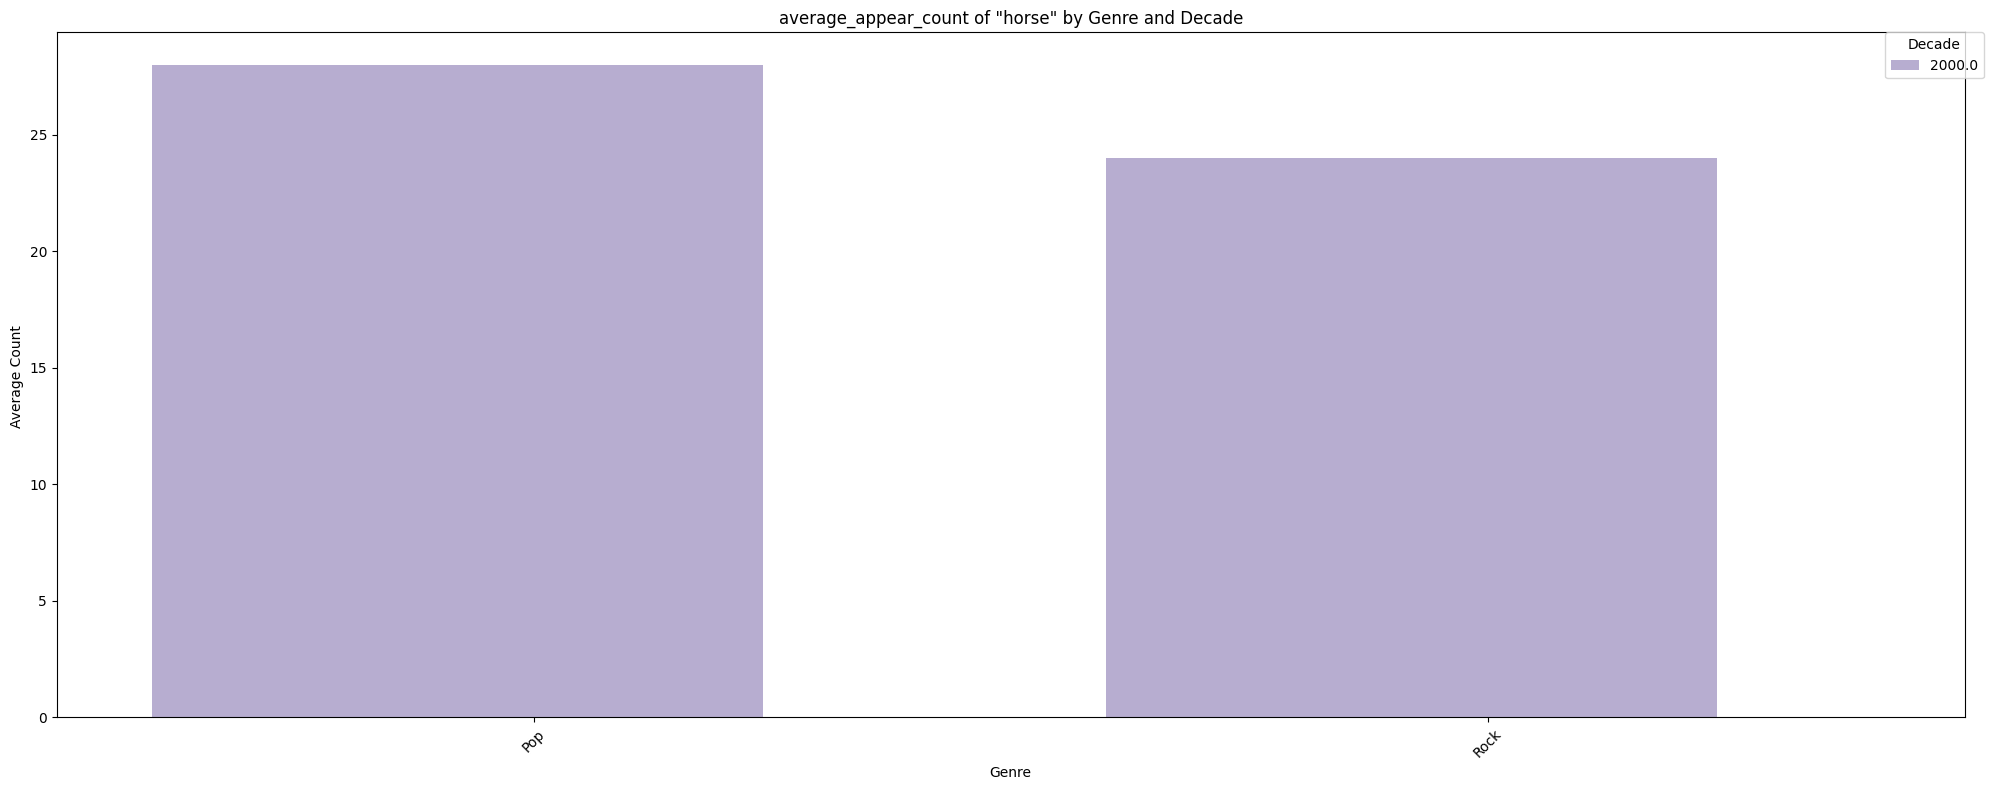

In [260]:
plot_object_distribution(average_df, 'person')
plot_object_distribution(average_df, 'person', 'average_appear_count')

plot_object_distribution(average_df, 'tie')
plot_object_distribution(average_df, 'tie', 'average_appear_count')

plot_object_distribution(average_df, 'book')
plot_object_distribution(average_df, 'book', 'average_appear_count')

plot_object_distribution(average_df, 'car')
plot_object_distribution(average_df, 'car', 'average_appear_count')

plot_object_distribution(average_df, 'horse')
plot_object_distribution(average_df, 'horse', 'average_appear_count')

